In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def real_data_target(size):
    data = Variable(torch.ones(size, 1)).to(device)
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size, 1)).to(device)
    return data

In [13]:
def imgs_to_vec(imgs, img_size=28):
    return imgs.view(imgs.size(0), img_size * img_size)

In [14]:
def vec_to_imgs(vec):
    return vec.view(vec.size(0), 1, 28, 28)

In [15]:
def noise(size, batch_size=128):
    n = Variable(torch.randn(size, batch_size))
    return n

In [16]:
log_data = []

def log(e, E, b, B, de, ge):
    row = {
        'epoch': e, 'epochs': E,
        'batch': b, 'batches': B,
        'derror': de, 'gerror': ge,
    }

def display_logs(e, E, b, B, de, ge, dr, df, batch_size=128):
    print(f"Epoch {e+1}/{E} ({(e/E)*100:.1f}%):"
          f" [{b*batch_size}/{B*batch_size}] ({(b/B)*100:.1f}%)"
          f" D Error: {de:.4f} G Error: {ge:.4f}") 

In [17]:
def display_images(imgs):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
    count = 0
    for y in range(4):
        for x in range(4):
            img = imgs[count].view(28, 28)
            axs[y][x].imshow(img, cmap="gray")
            count += 1
    plt.show()
            

## Data

In [18]:
def mnist_data():
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])
    out_dir = '/kaggle/working/mnist/'
    return datasets.MNIST(root=out_dir, train=True,
                          transform=compose, download=True)

In [19]:
data = mnist_data()

data_loader = DataLoader(data, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.88MB/s]


## Neural Networks

In [20]:
class DiscriminatorNet(nn.Module):
    def __init__(self, n_out=1, img_size=28):
        super(DiscriminatorNet, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [21]:
class GeneratorNet(nn.Module):
    def __init__(self, batch_size=128, img_size=28):
        super(GeneratorNet, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(batch_size, 256),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
        )
        self.out = nn.Sequential(
            nn.Linear(1024, img_size * img_size),
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [22]:
discriminator = DiscriminatorNet().to(device)
generator = GeneratorNet().to(device)

## Pre-training Setup

In [23]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [24]:
loss = nn.BCELoss()

In [25]:
EPOCHS = 100

## Train Models

In [26]:
def train_discriminator(dmodel, optimizer, loss_func, real_data, fake_data):
    optimizer.zero_grad()
    # Train on real data
    pred_real = dmodel(real_data)
    error_real = loss_func(pred_real, real_data_target(real_data.size(0)))
    error_real.backward()
    # Train on fake data
    pred_fake = dmodel(fake_data)
    error_fake = loss_func(pred_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    # Update weights
    optimizer.step()
    # Return error
    return error_real + error_fake, pred_real, pred_fake

In [27]:
def train_generator(dmodel, optimizer, loss_func, fake_data):
    optimizer.zero_grad()
    pred = dmodel(fake_data)
    error = loss_func(pred, real_data_target(pred.size(0)))
    error.backward()
    optimizer.step()
    return error

## Generate Samples for Testing

In [28]:
NUM_BATCHES = len(data_loader)
DISPLAY_EVERY = 1000

In [29]:
num_samples = 16
test_noise = noise(num_samples)
test_noise

tensor([[ 0.5907,  0.9781, -0.3610,  ...,  1.0096, -0.4842, -0.8110],
        [ 0.6189,  0.4552, -0.0698,  ..., -2.1747,  1.0854, -0.1522],
        [-1.0897, -0.6369,  0.5803,  ...,  2.0762,  0.4336, -0.7350],
        ...,
        [-2.2552, -0.7283, -0.2310,  ...,  2.0372, -0.2881, -0.2795],
        [-1.3306, -0.5291, -0.4892,  ..., -0.7821, -0.5245,  0.5956],
        [-1.7556,  0.3384, -0.1618,  ..., -0.3887,  0.2157, -1.5590]])

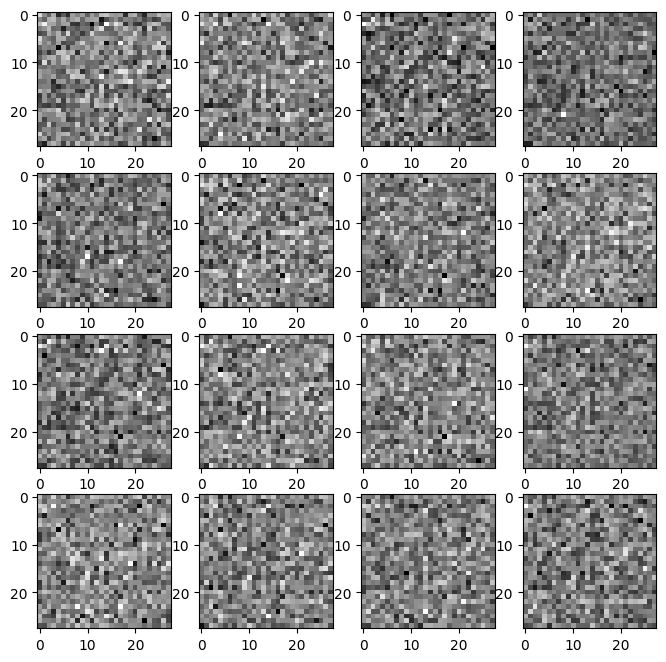

Epoch 1/100 (0.0%): [0/60032] (0.0%) D Error: 1.4025 G Error: 0.6882


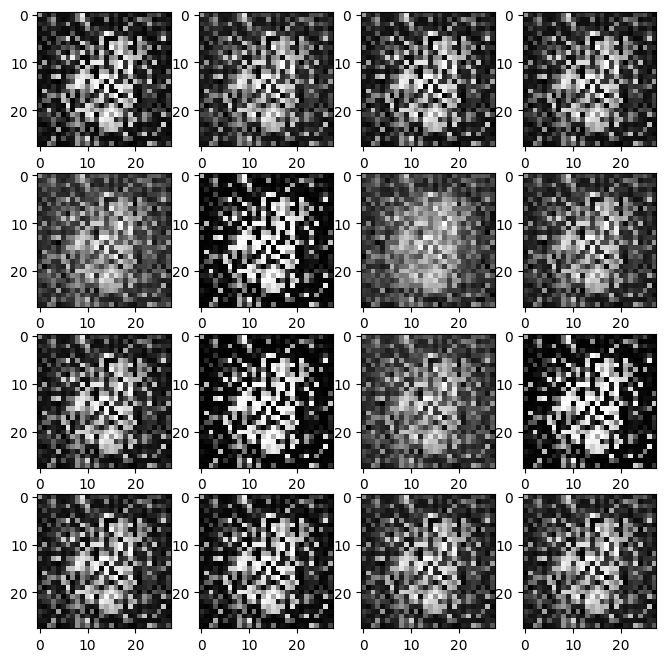

Epoch 2/100 (1.0%): [0/60032] (0.0%) D Error: 1.2126 G Error: 3.1933


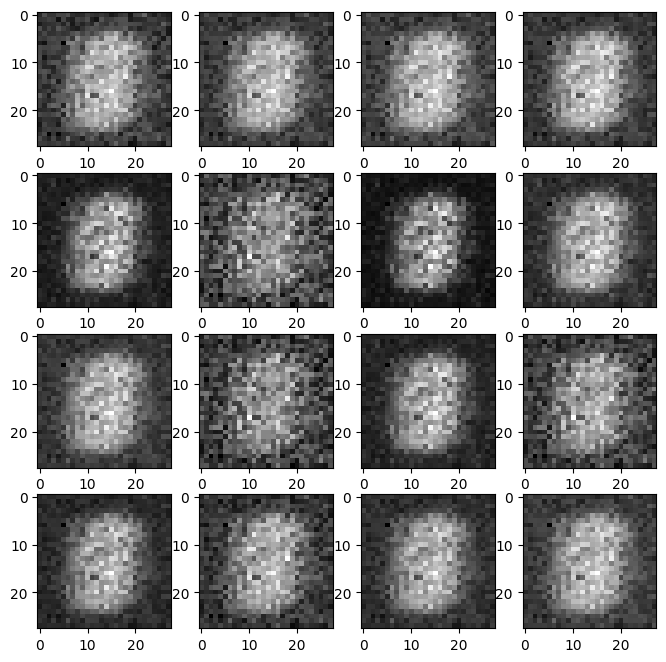

Epoch 3/100 (2.0%): [0/60032] (0.0%) D Error: 1.9498 G Error: 0.4649


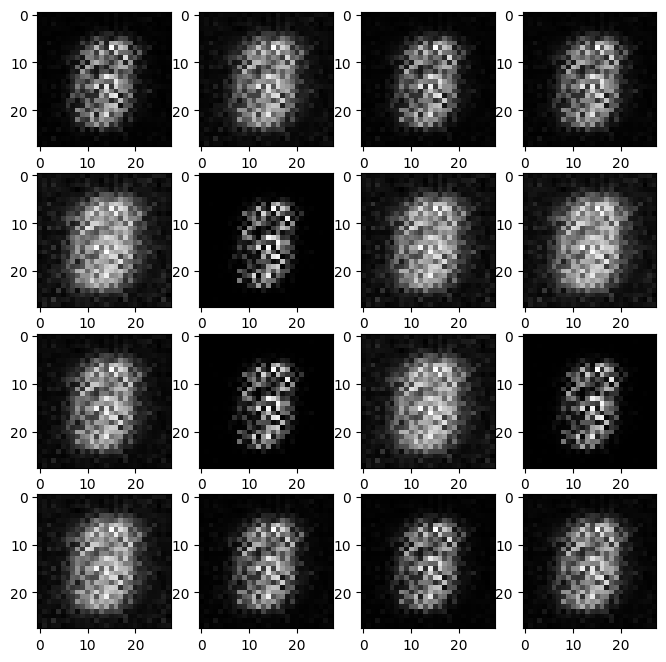

Epoch 4/100 (3.0%): [0/60032] (0.0%) D Error: 0.8307 G Error: 2.5559


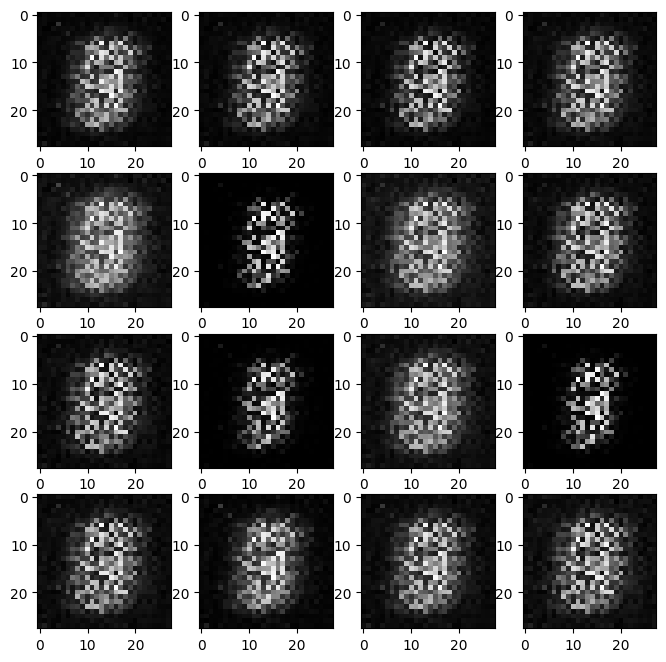

Epoch 5/100 (4.0%): [0/60032] (0.0%) D Error: 0.5983 G Error: 3.3723


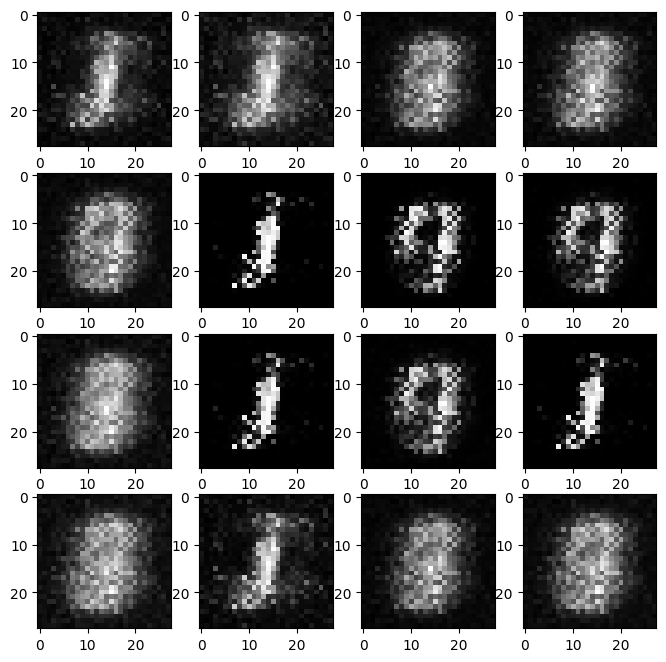

Epoch 6/100 (5.0%): [0/60032] (0.0%) D Error: 0.6545 G Error: 3.3481


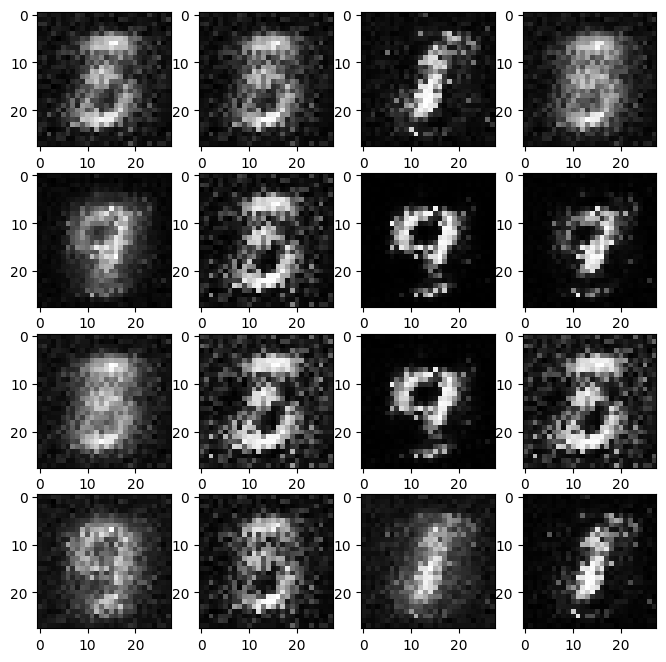

Epoch 7/100 (6.0%): [0/60032] (0.0%) D Error: 0.6295 G Error: 2.1739


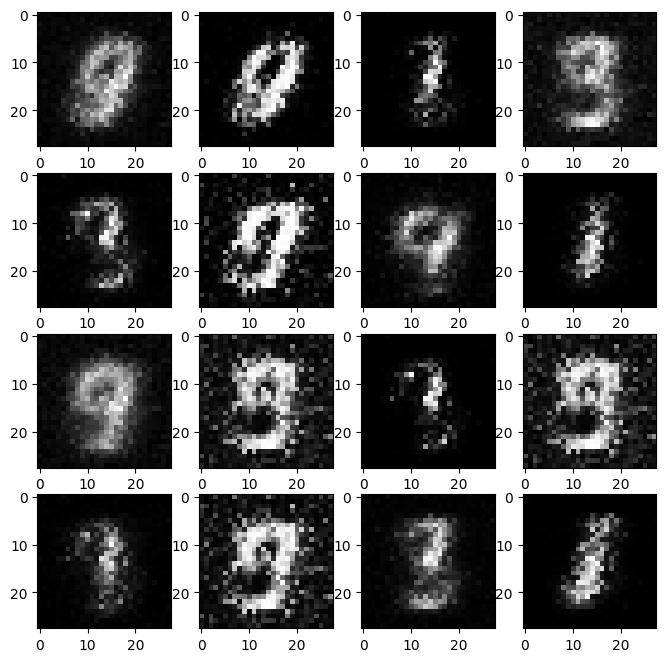

Epoch 8/100 (7.0%): [0/60032] (0.0%) D Error: 0.5738 G Error: 2.4513


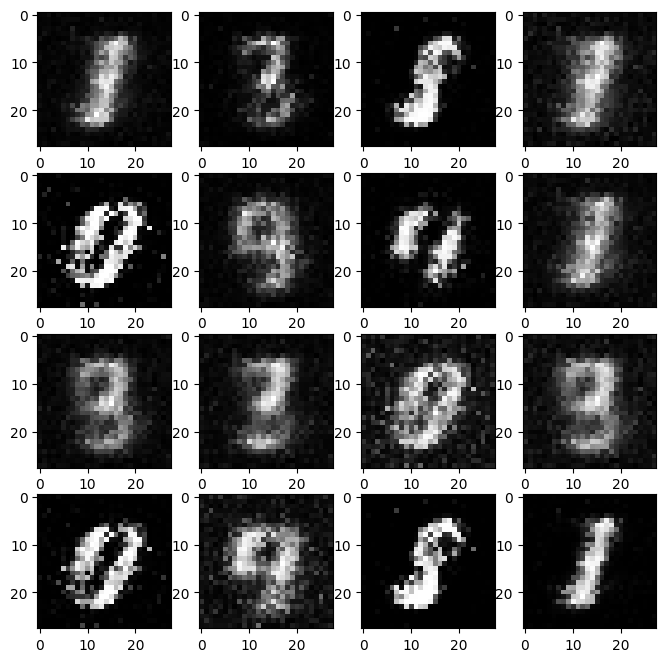

Epoch 9/100 (8.0%): [0/60032] (0.0%) D Error: 0.5214 G Error: 2.2985


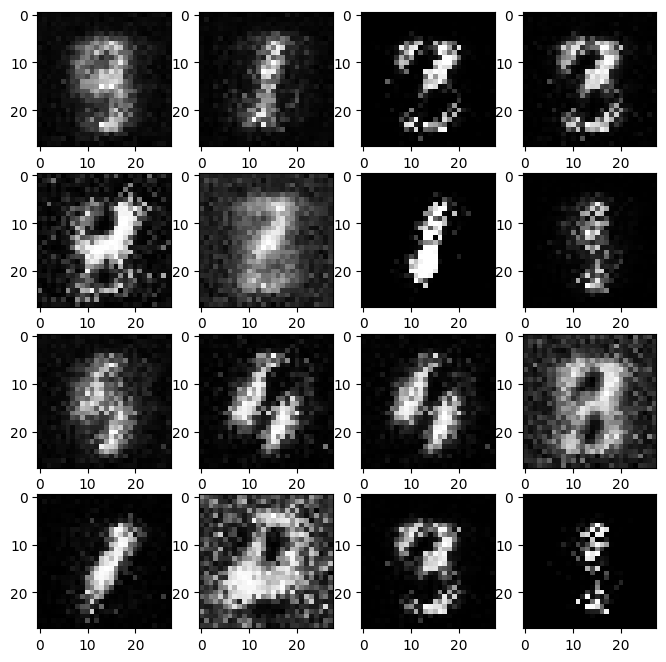

Epoch 10/100 (9.0%): [0/60032] (0.0%) D Error: 0.2001 G Error: 3.3583


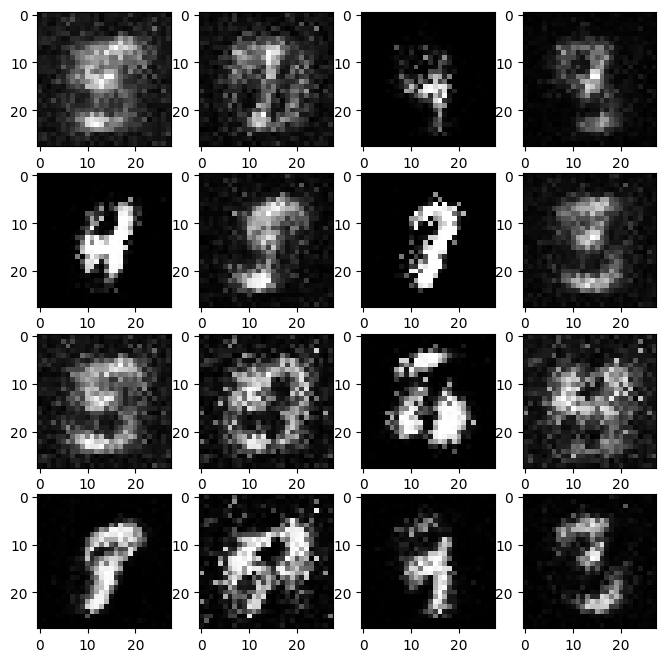

Epoch 11/100 (10.0%): [0/60032] (0.0%) D Error: 0.5498 G Error: 2.8726


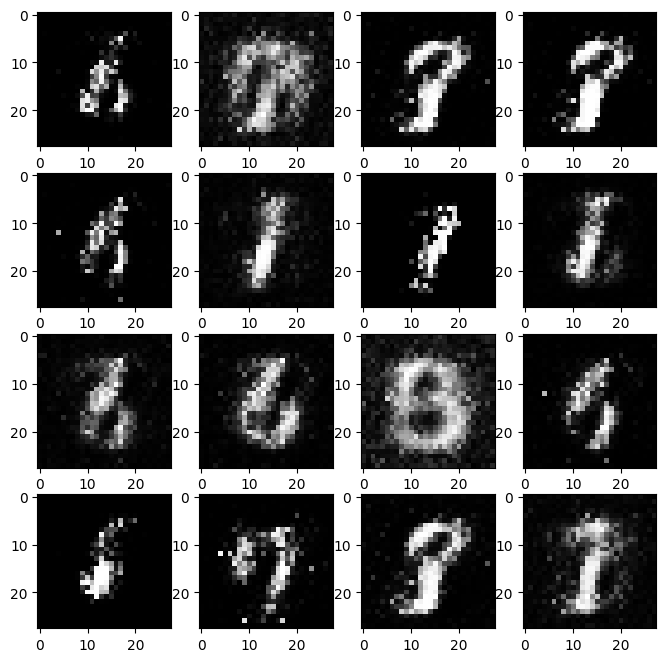

Epoch 12/100 (11.0%): [0/60032] (0.0%) D Error: 0.4266 G Error: 3.6020


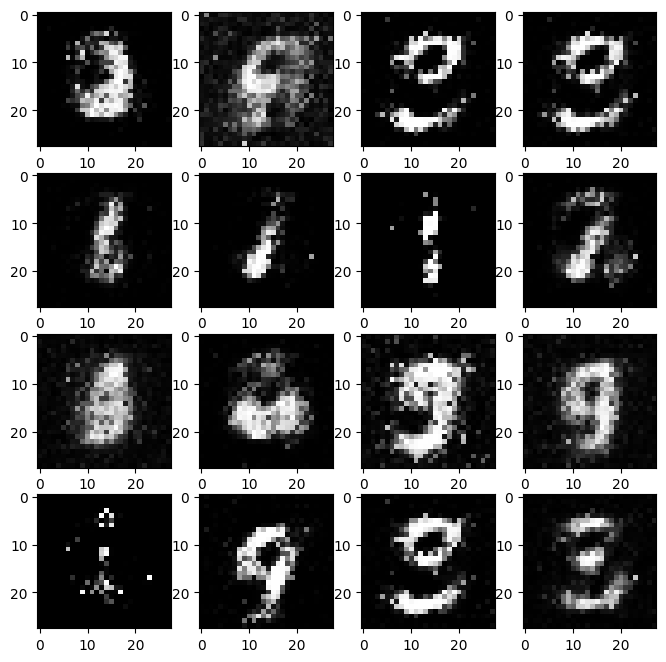

Epoch 13/100 (12.0%): [0/60032] (0.0%) D Error: 0.4046 G Error: 2.5336


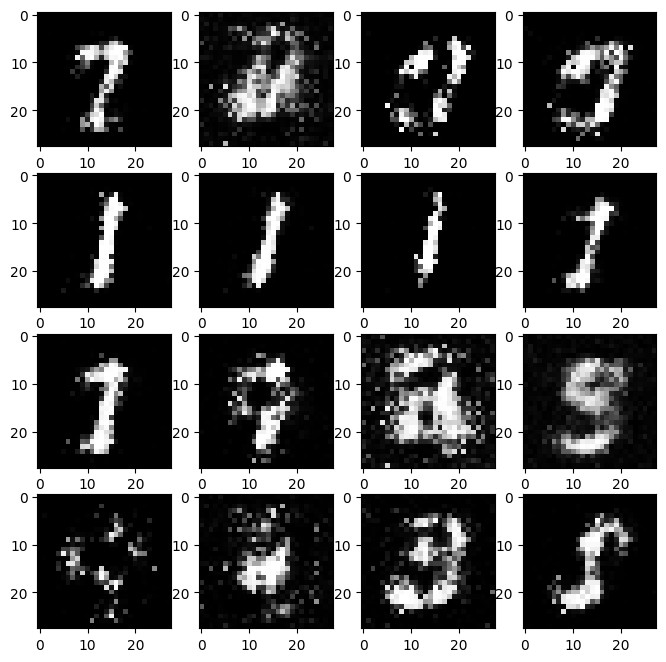

Epoch 14/100 (13.0%): [0/60032] (0.0%) D Error: 0.4106 G Error: 2.4902


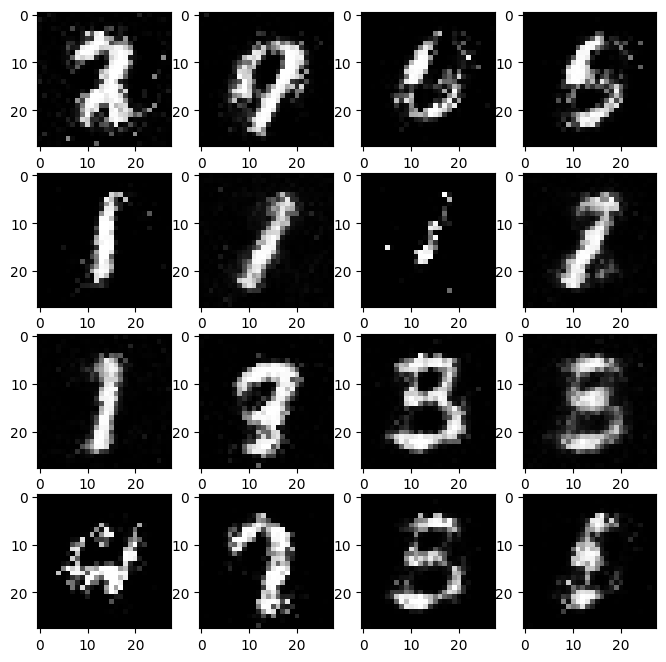

Epoch 15/100 (14.0%): [0/60032] (0.0%) D Error: 0.5453 G Error: 2.6562


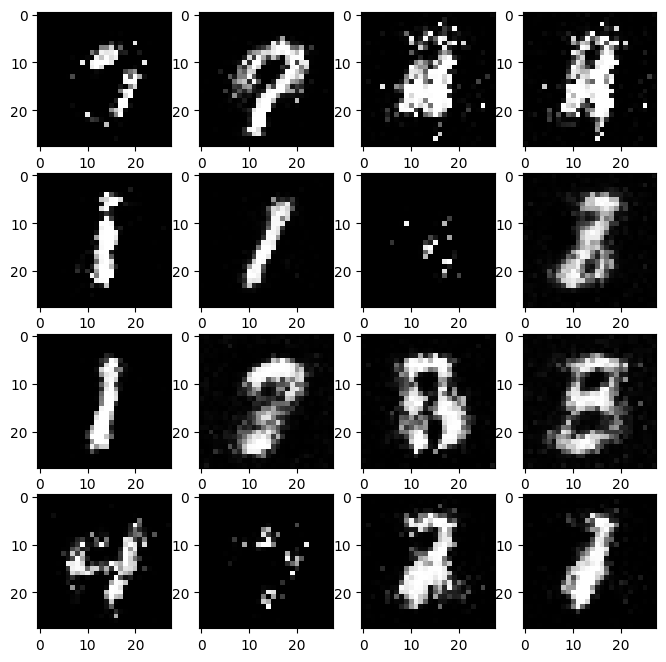

Epoch 16/100 (15.0%): [0/60032] (0.0%) D Error: 0.4946 G Error: 2.1780


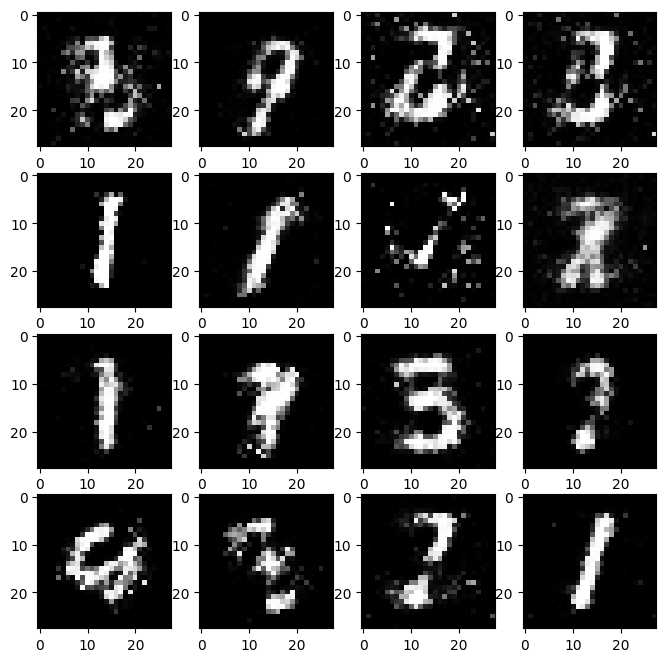

Epoch 17/100 (16.0%): [0/60032] (0.0%) D Error: 0.7513 G Error: 2.0300


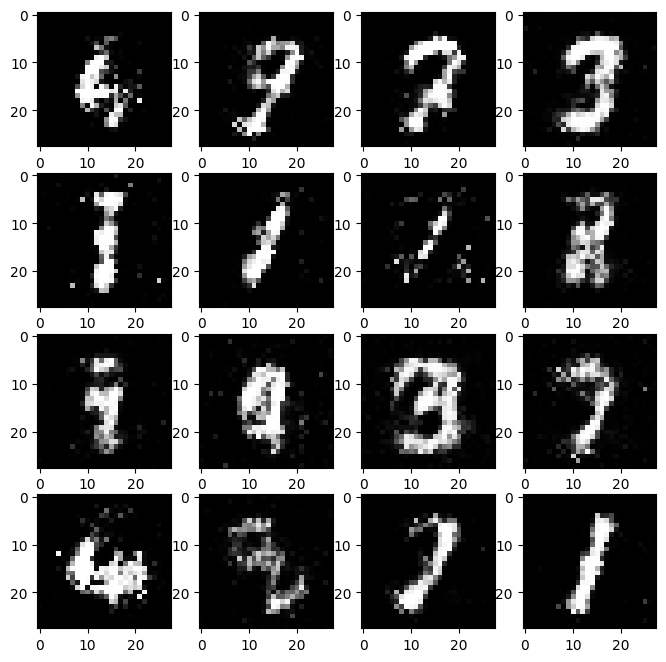

Epoch 18/100 (17.0%): [0/60032] (0.0%) D Error: 0.5890 G Error: 2.3714


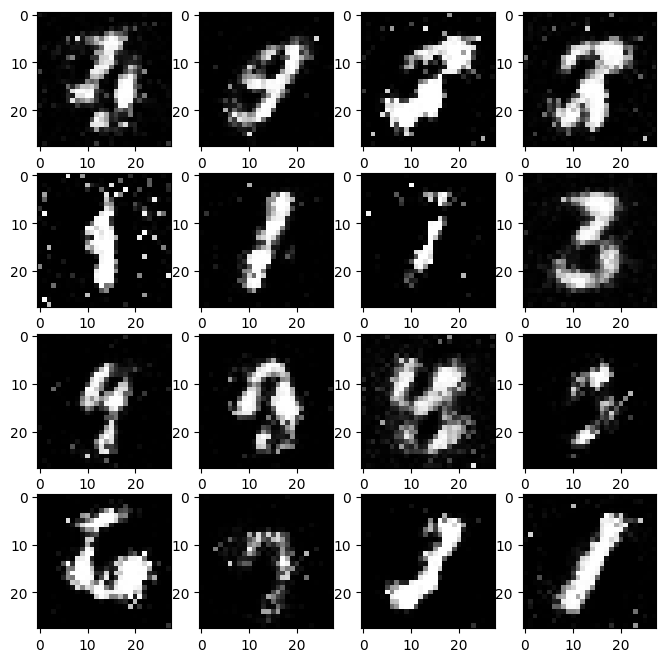

Epoch 19/100 (18.0%): [0/60032] (0.0%) D Error: 0.7628 G Error: 1.9510


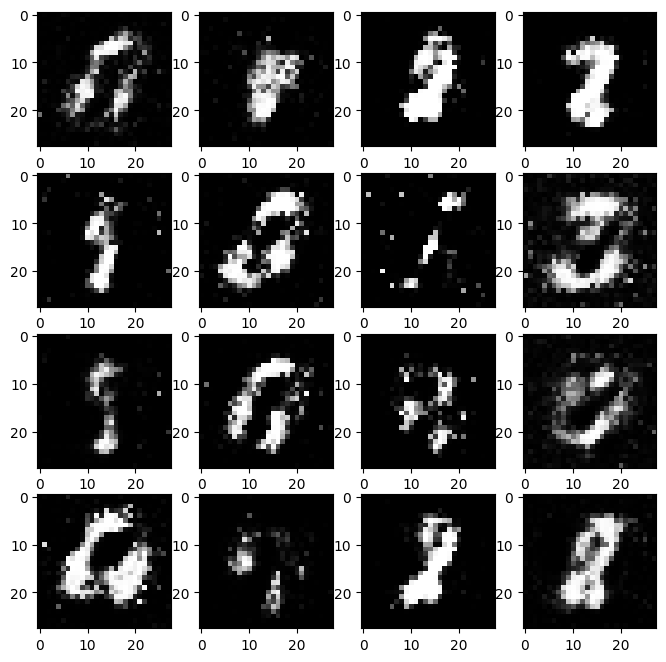

Epoch 20/100 (19.0%): [0/60032] (0.0%) D Error: 0.5748 G Error: 2.8913


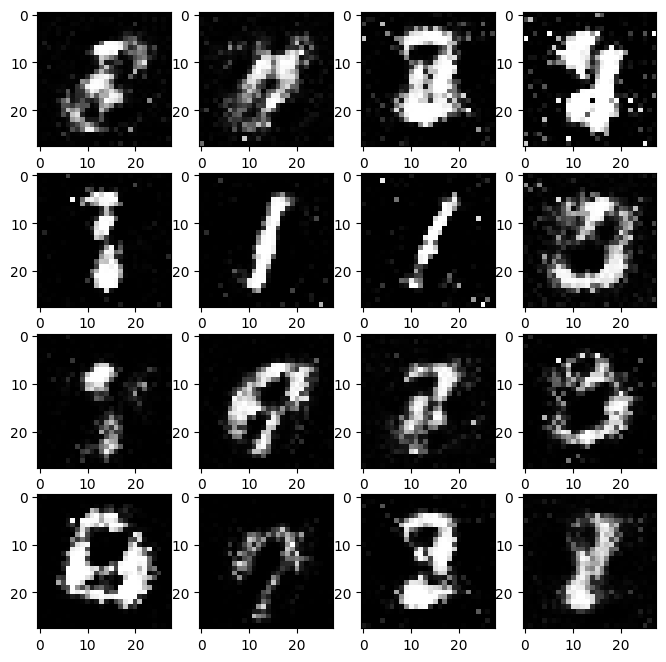

Epoch 21/100 (20.0%): [0/60032] (0.0%) D Error: 0.9218 G Error: 1.9947


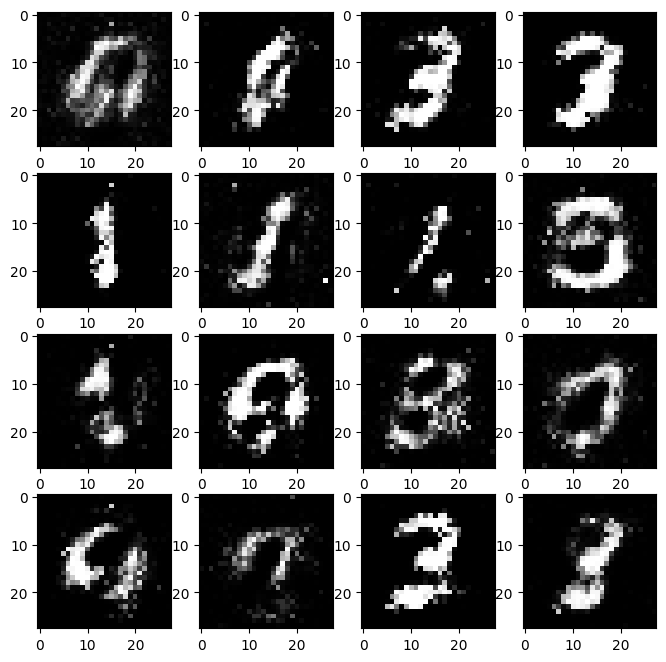

Epoch 22/100 (21.0%): [0/60032] (0.0%) D Error: 0.8476 G Error: 1.3952


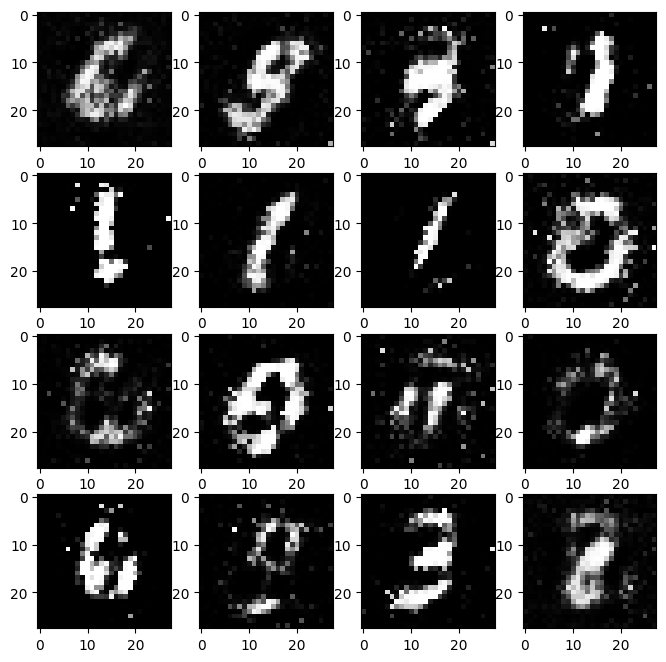

Epoch 23/100 (22.0%): [0/60032] (0.0%) D Error: 0.7581 G Error: 2.5353


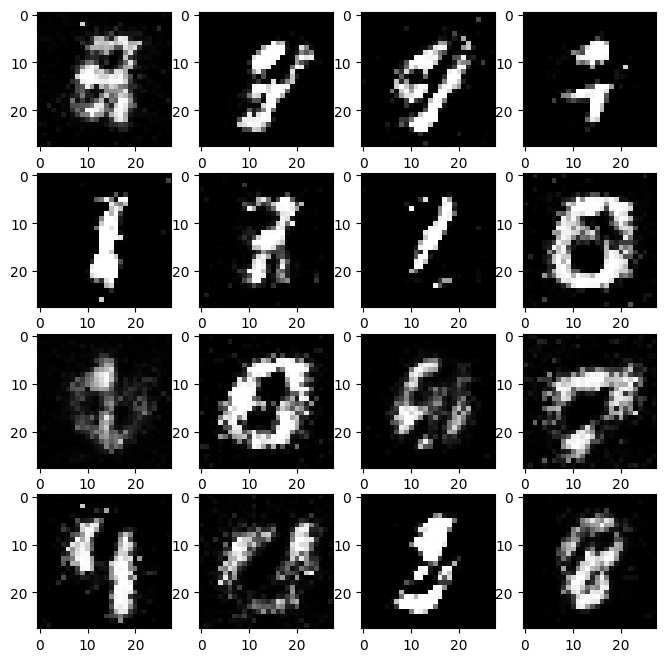

Epoch 24/100 (23.0%): [0/60032] (0.0%) D Error: 0.9779 G Error: 1.5388


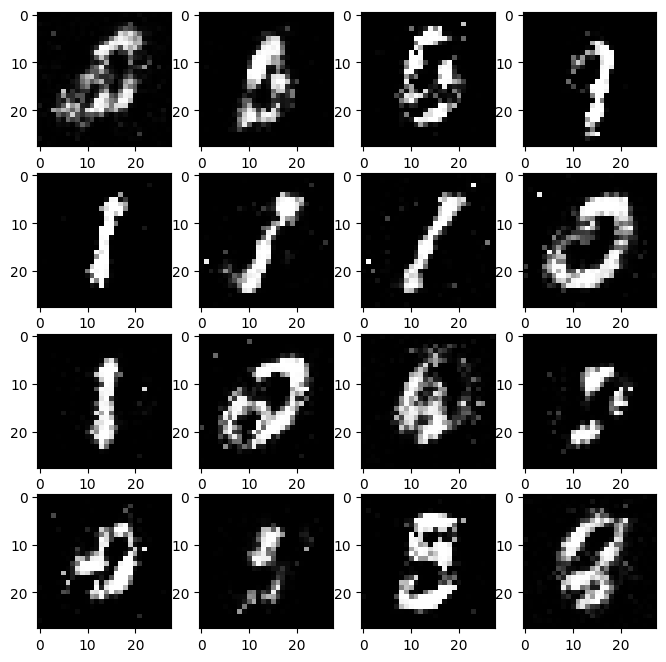

Epoch 25/100 (24.0%): [0/60032] (0.0%) D Error: 0.7736 G Error: 2.0835


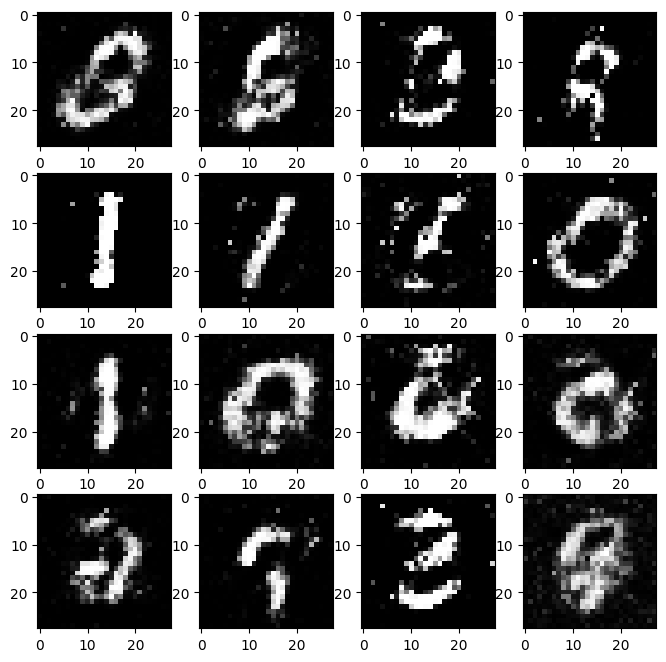

Epoch 26/100 (25.0%): [0/60032] (0.0%) D Error: 0.7484 G Error: 1.8432


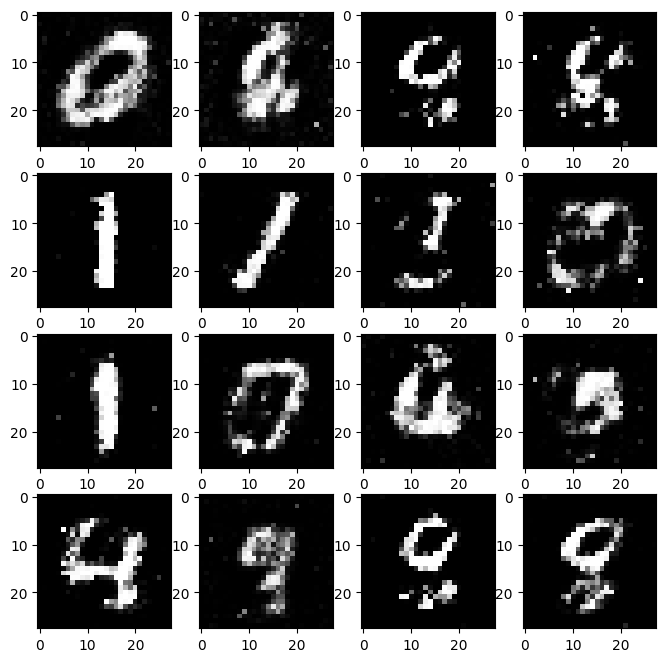

Epoch 27/100 (26.0%): [0/60032] (0.0%) D Error: 0.7847 G Error: 2.0174


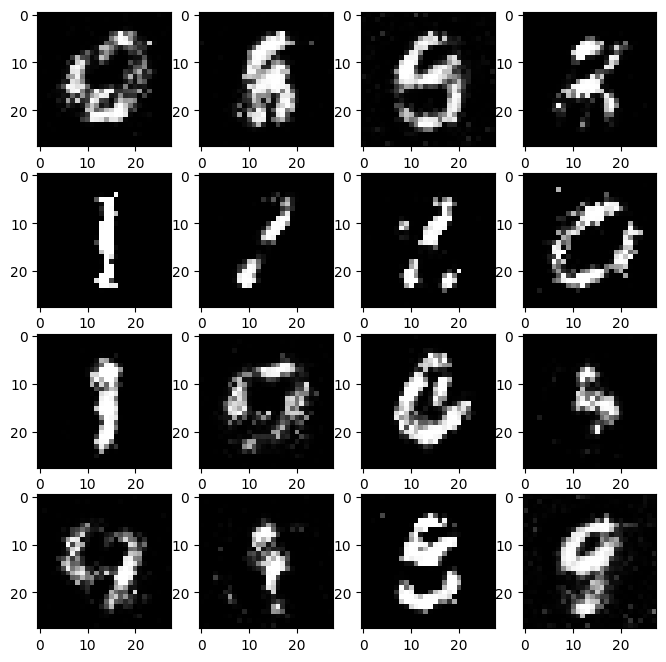

Epoch 28/100 (27.0%): [0/60032] (0.0%) D Error: 0.8298 G Error: 1.7105


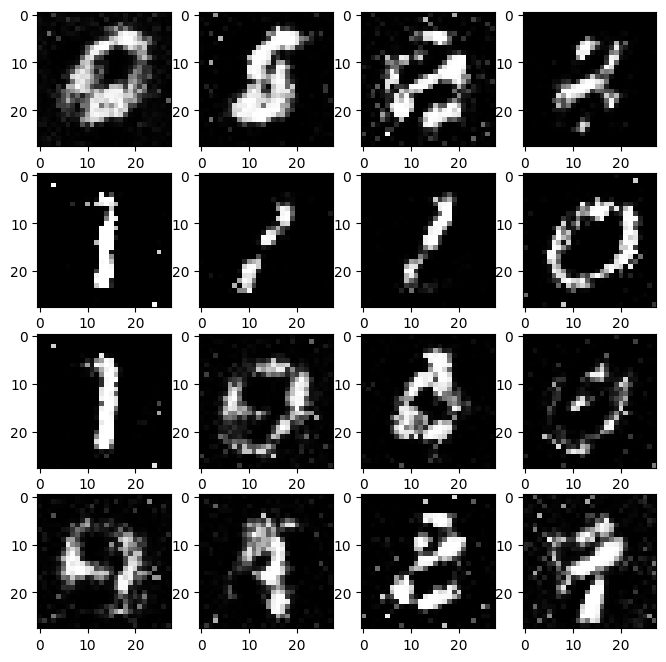

Epoch 29/100 (28.0%): [0/60032] (0.0%) D Error: 0.9532 G Error: 1.9981


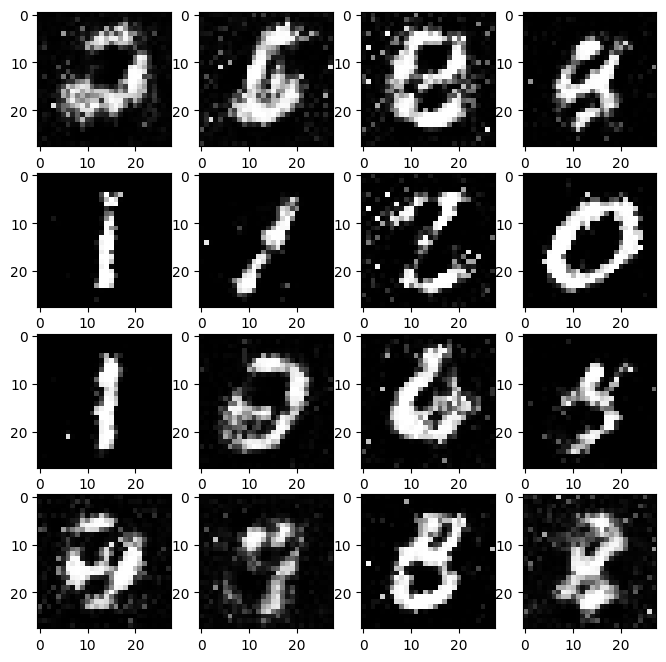

Epoch 30/100 (29.0%): [0/60032] (0.0%) D Error: 1.1635 G Error: 1.2299


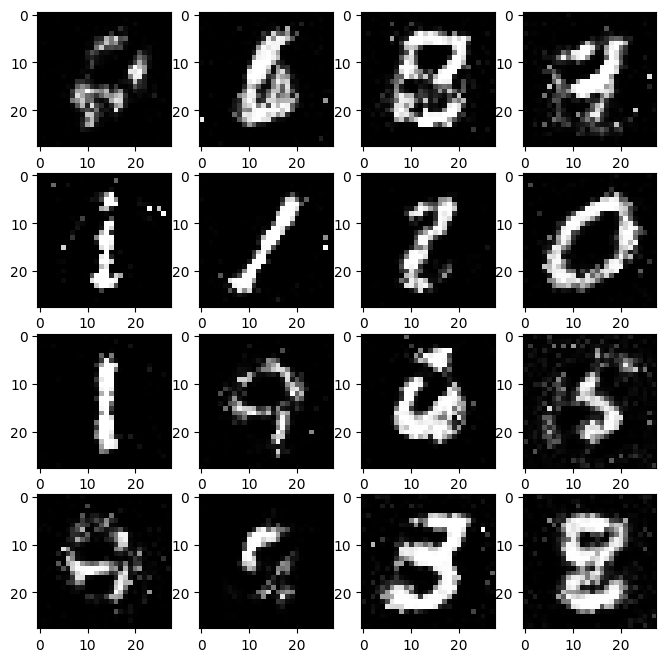

Epoch 31/100 (30.0%): [0/60032] (0.0%) D Error: 0.9538 G Error: 1.3138


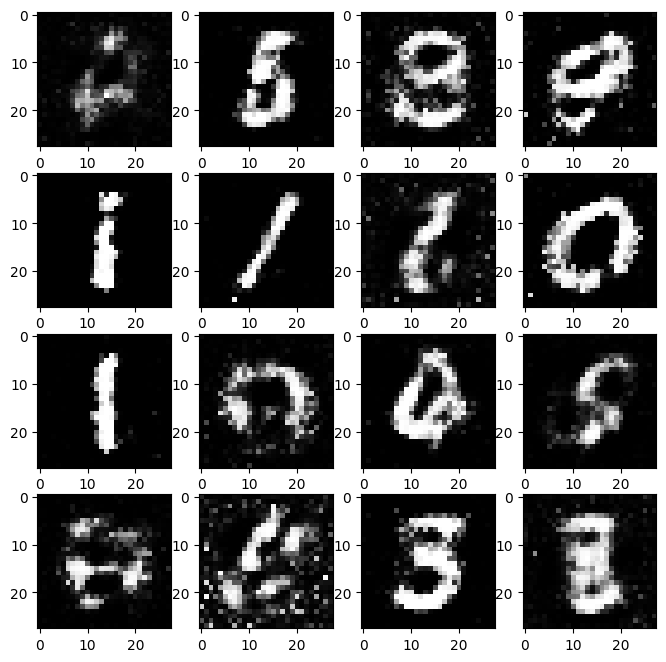

Epoch 32/100 (31.0%): [0/60032] (0.0%) D Error: 1.0988 G Error: 1.4191


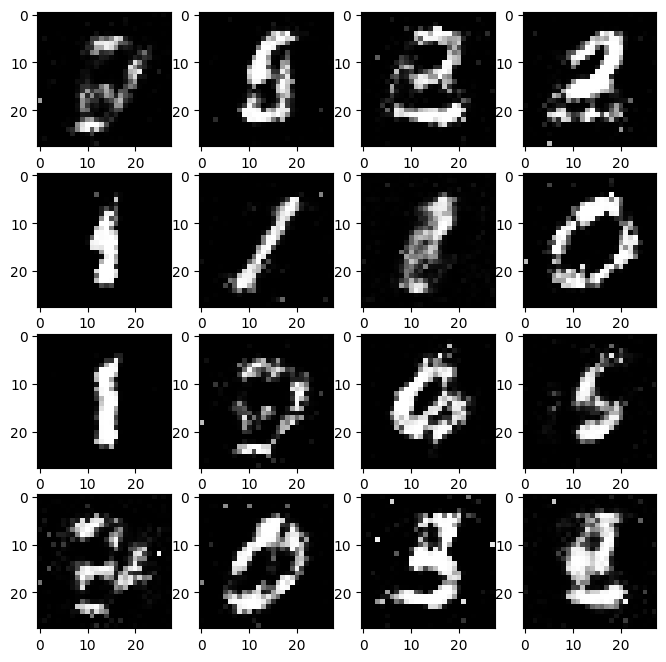

Epoch 33/100 (32.0%): [0/60032] (0.0%) D Error: 1.1346 G Error: 1.2900


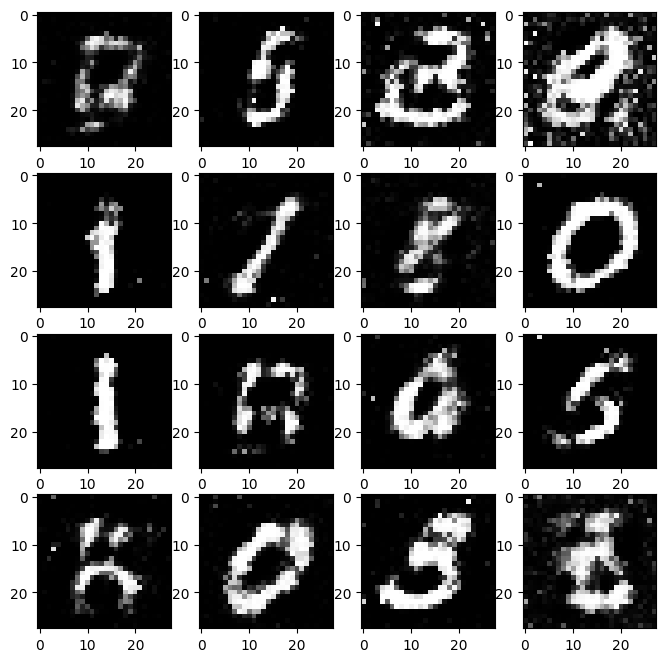

Epoch 34/100 (33.0%): [0/60032] (0.0%) D Error: 0.8428 G Error: 1.3139


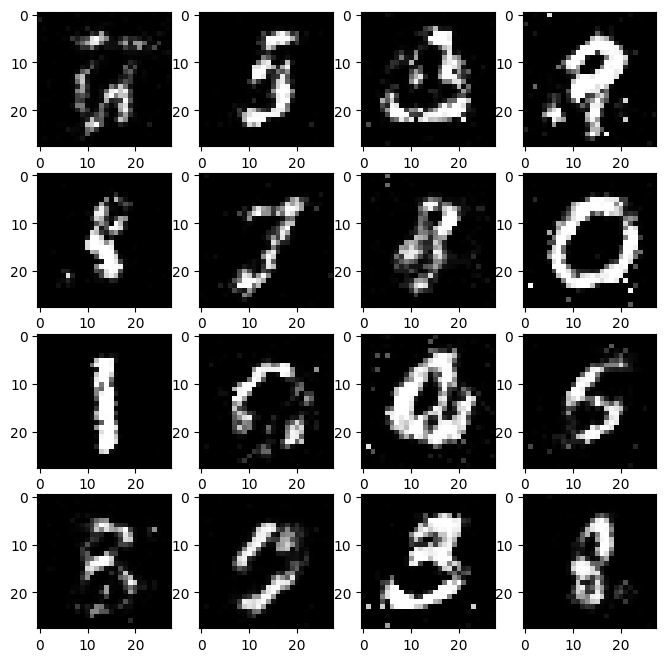

Epoch 35/100 (34.0%): [0/60032] (0.0%) D Error: 0.8316 G Error: 1.4449


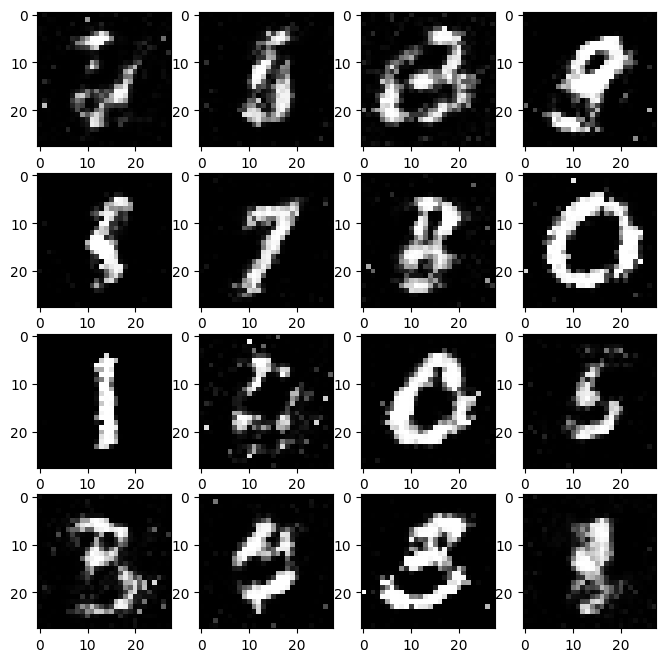

Epoch 36/100 (35.0%): [0/60032] (0.0%) D Error: 0.9542 G Error: 1.6929


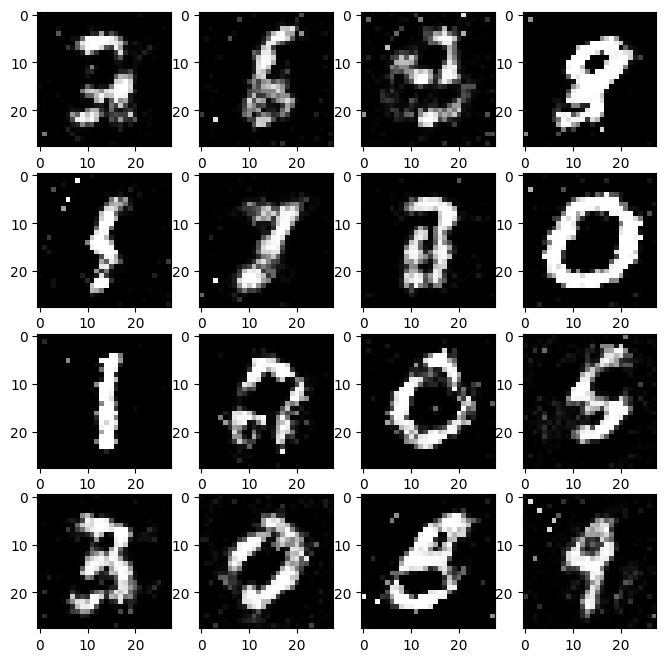

Epoch 37/100 (36.0%): [0/60032] (0.0%) D Error: 0.8947 G Error: 1.7537


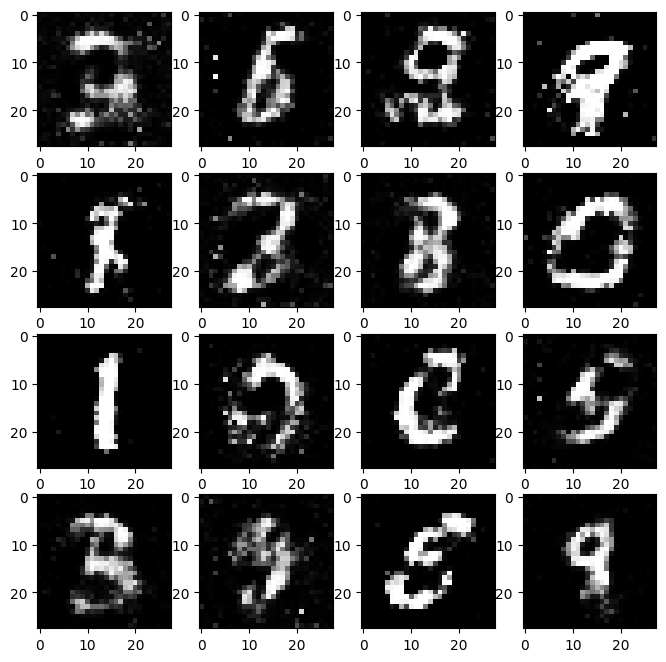

Epoch 38/100 (37.0%): [0/60032] (0.0%) D Error: 0.8480 G Error: 1.7020


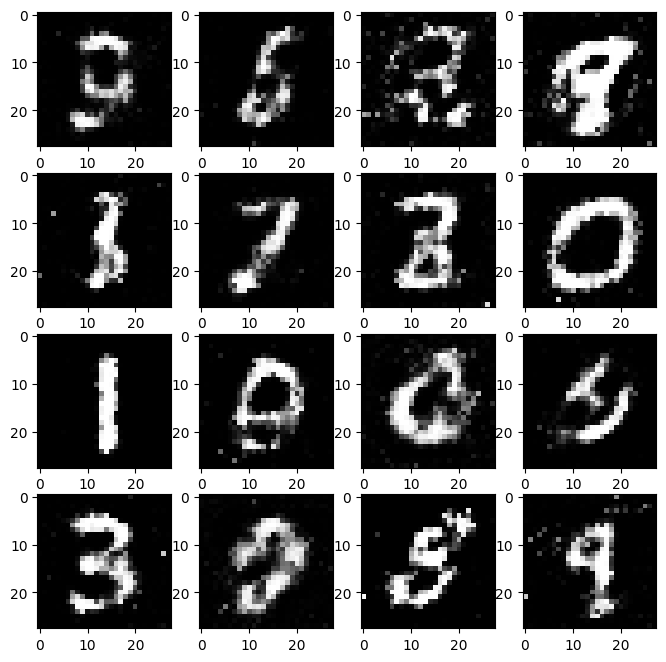

Epoch 39/100 (38.0%): [0/60032] (0.0%) D Error: 0.9422 G Error: 1.5454


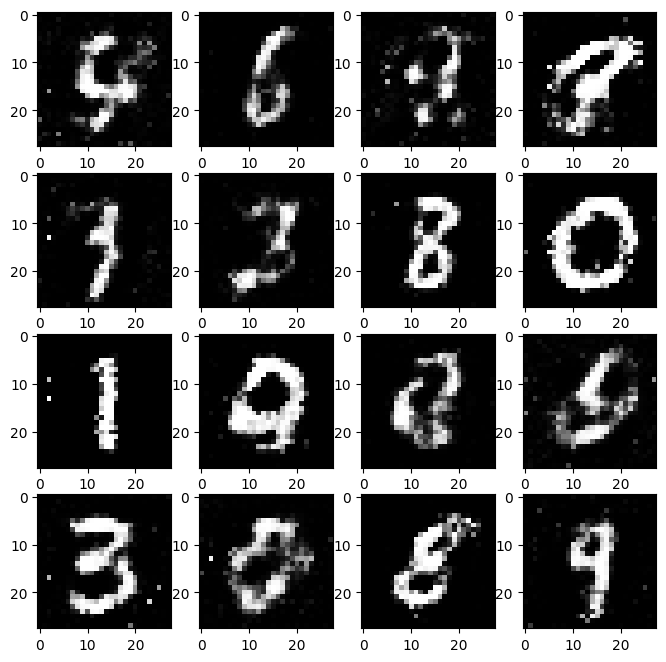

Epoch 40/100 (39.0%): [0/60032] (0.0%) D Error: 0.8287 G Error: 1.4157


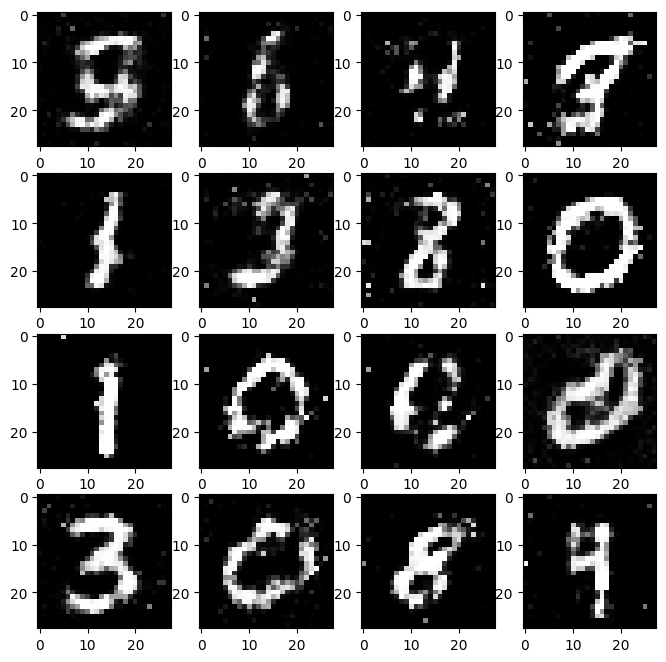

Epoch 41/100 (40.0%): [0/60032] (0.0%) D Error: 0.9562 G Error: 1.0715


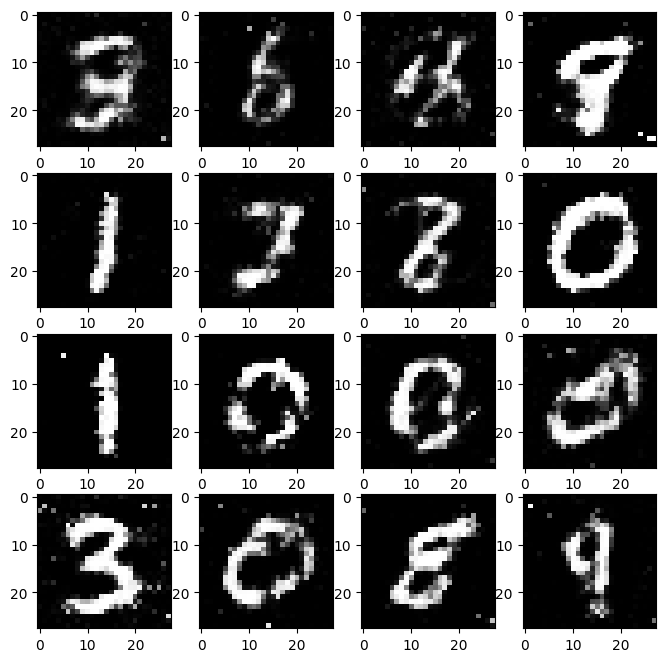

Epoch 42/100 (41.0%): [0/60032] (0.0%) D Error: 1.0067 G Error: 1.3300


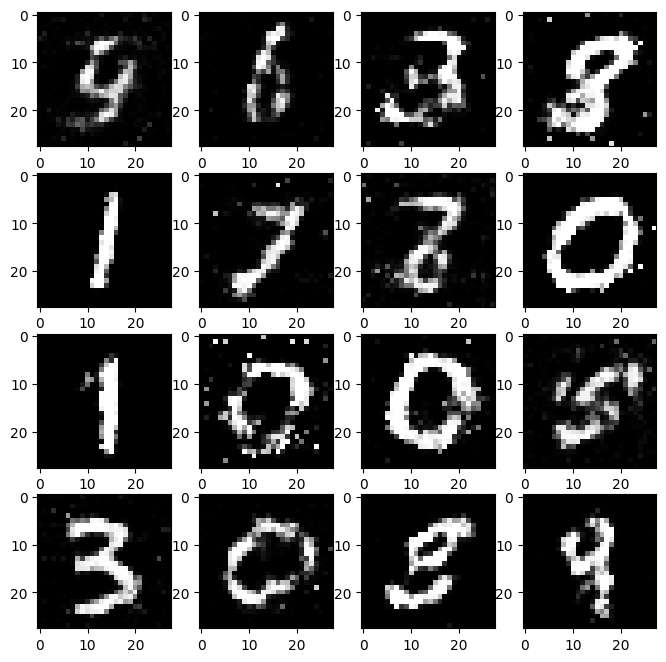

Epoch 43/100 (42.0%): [0/60032] (0.0%) D Error: 0.9601 G Error: 1.3739


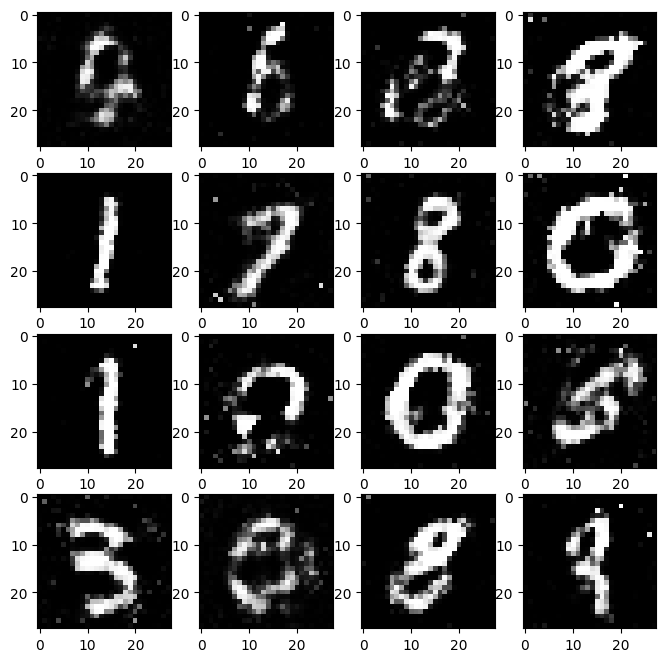

Epoch 44/100 (43.0%): [0/60032] (0.0%) D Error: 0.9962 G Error: 1.4294


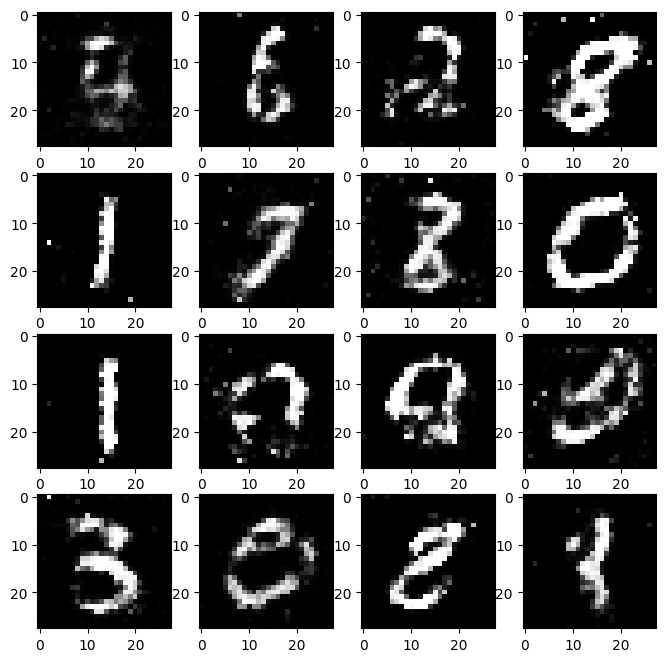

Epoch 45/100 (44.0%): [0/60032] (0.0%) D Error: 1.0396 G Error: 1.4010


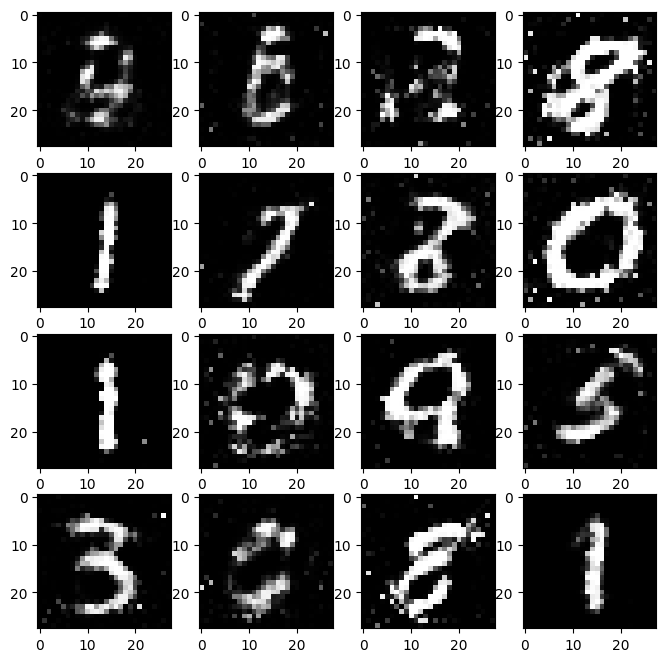

Epoch 46/100 (45.0%): [0/60032] (0.0%) D Error: 0.9757 G Error: 1.4265


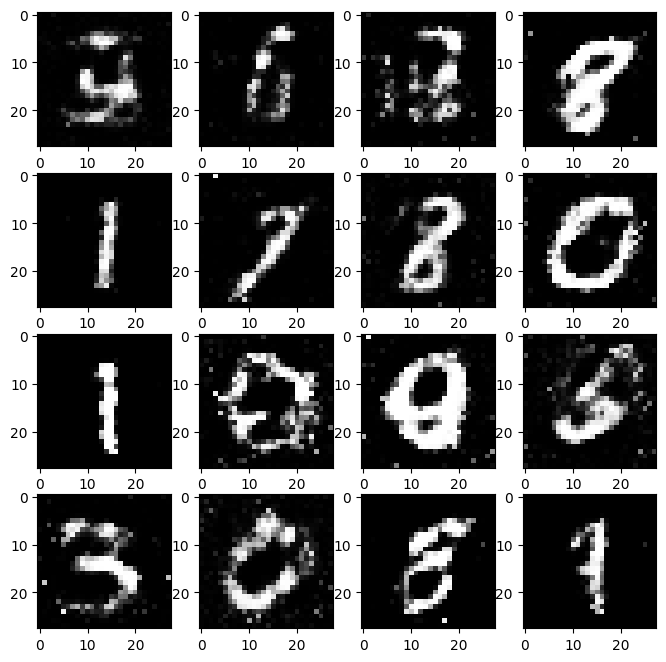

Epoch 47/100 (46.0%): [0/60032] (0.0%) D Error: 1.2212 G Error: 1.1427


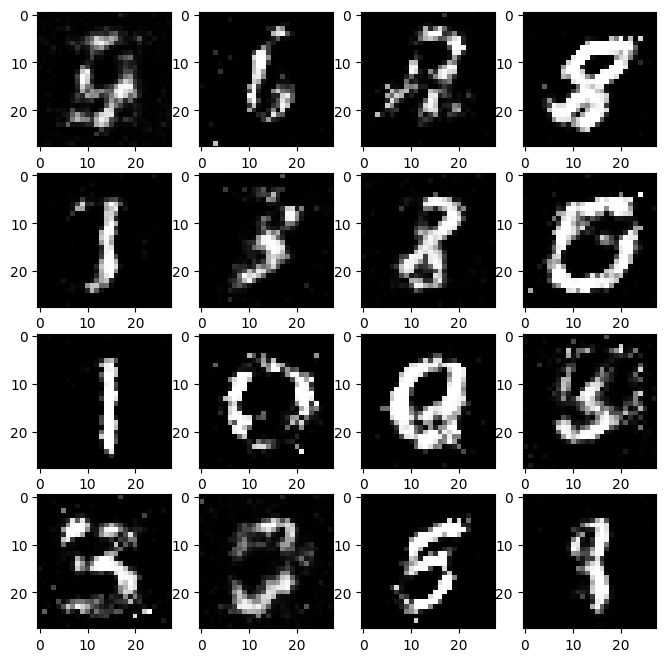

Epoch 48/100 (47.0%): [0/60032] (0.0%) D Error: 0.9718 G Error: 1.3048


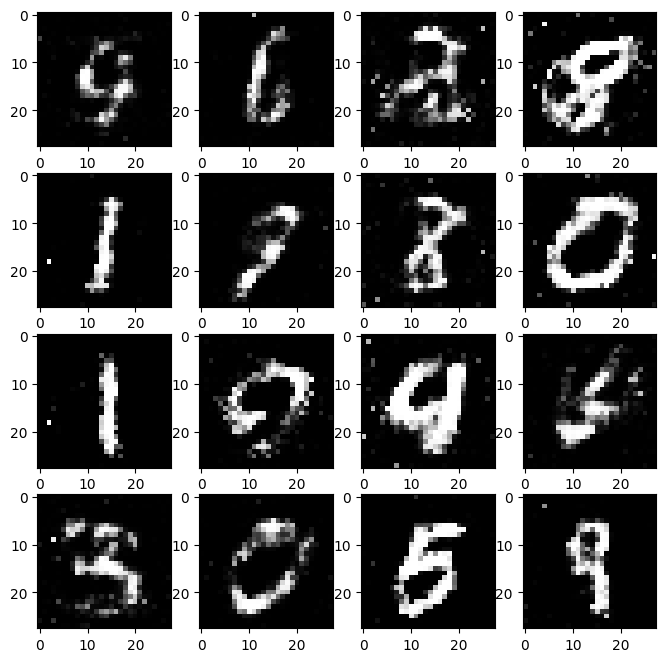

Epoch 49/100 (48.0%): [0/60032] (0.0%) D Error: 1.0181 G Error: 1.4670


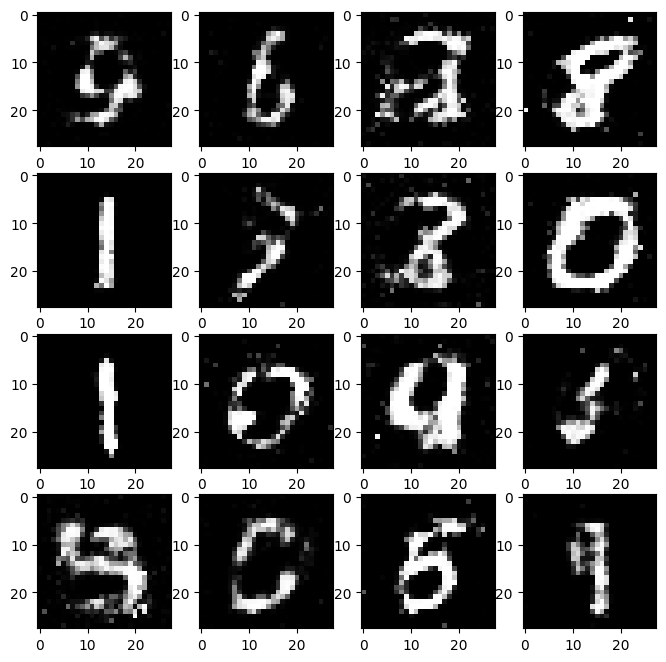

Epoch 50/100 (49.0%): [0/60032] (0.0%) D Error: 0.9073 G Error: 1.1865


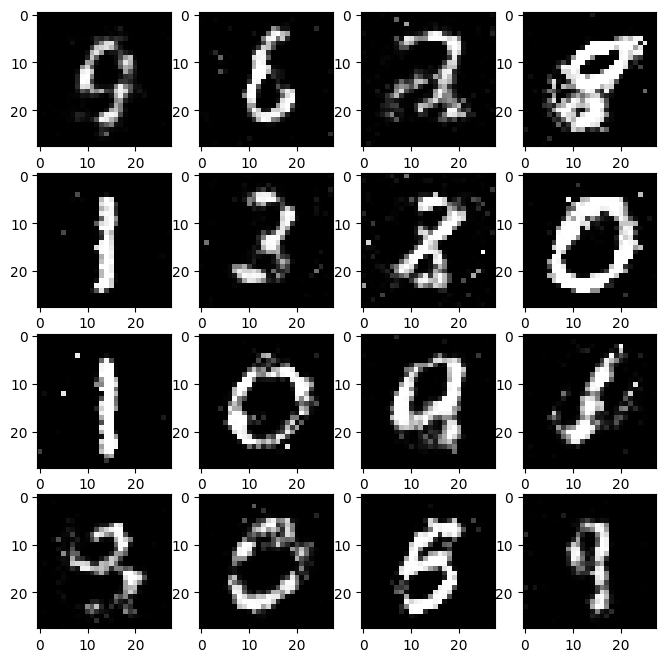

Epoch 51/100 (50.0%): [0/60032] (0.0%) D Error: 1.0071 G Error: 1.0656


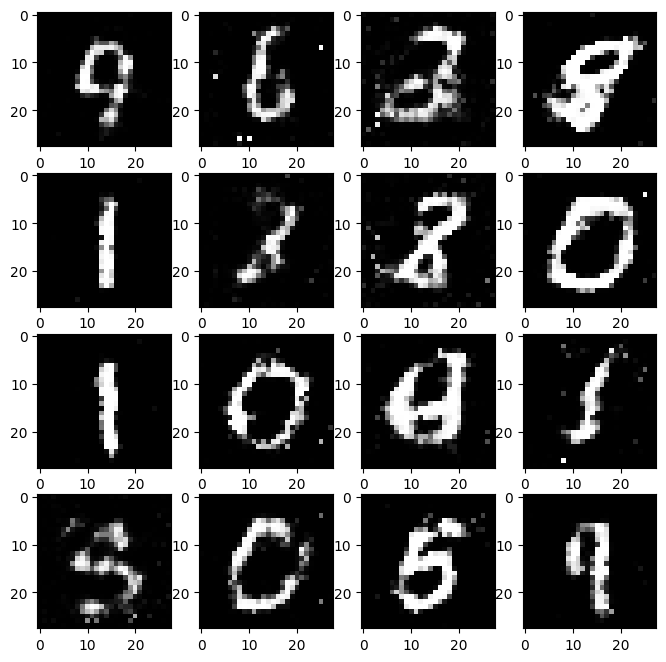

Epoch 52/100 (51.0%): [0/60032] (0.0%) D Error: 1.0687 G Error: 1.3265


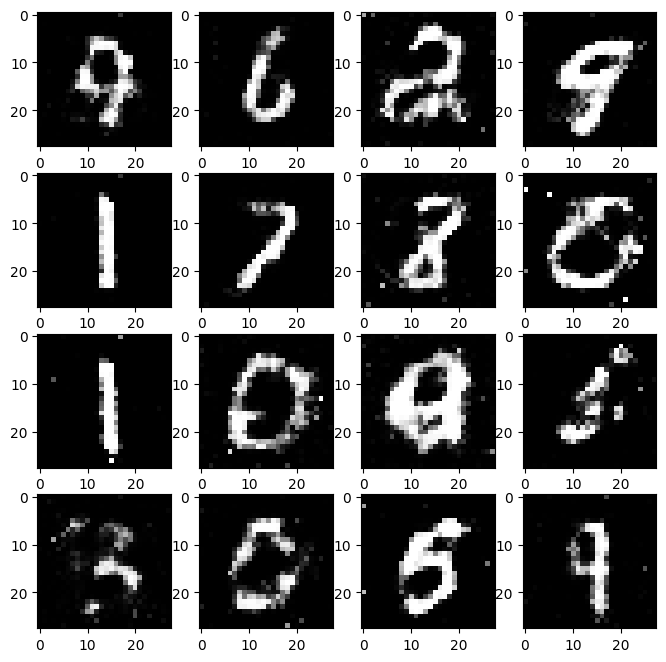

Epoch 53/100 (52.0%): [0/60032] (0.0%) D Error: 1.0438 G Error: 1.4260


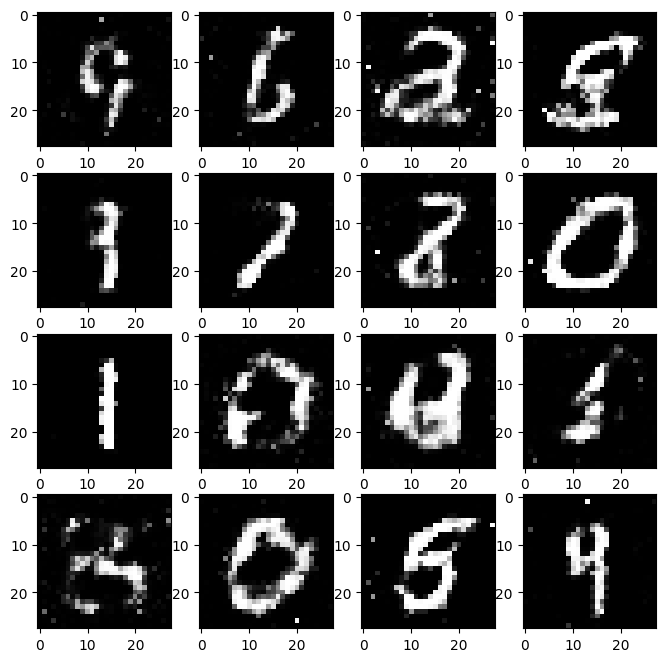

Epoch 54/100 (53.0%): [0/60032] (0.0%) D Error: 1.0967 G Error: 1.1989


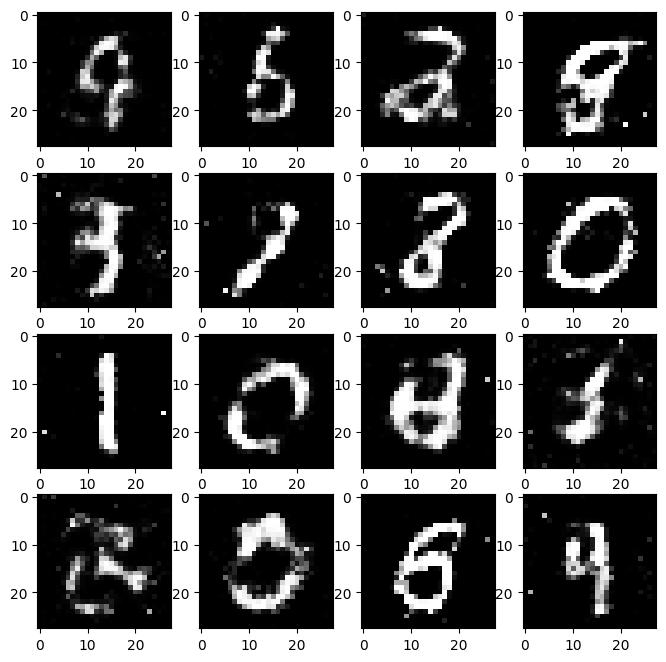

Epoch 55/100 (54.0%): [0/60032] (0.0%) D Error: 1.2550 G Error: 1.0825


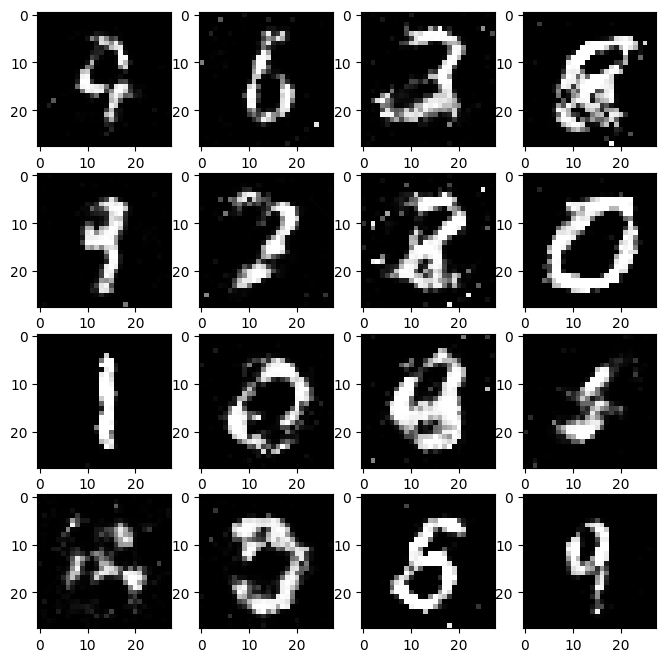

Epoch 56/100 (55.0%): [0/60032] (0.0%) D Error: 1.0868 G Error: 1.0911


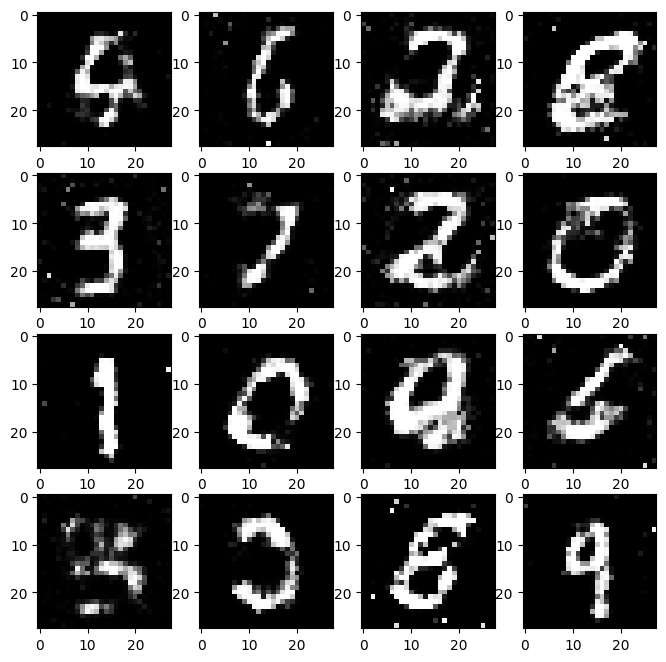

Epoch 57/100 (56.0%): [0/60032] (0.0%) D Error: 1.0827 G Error: 1.0363


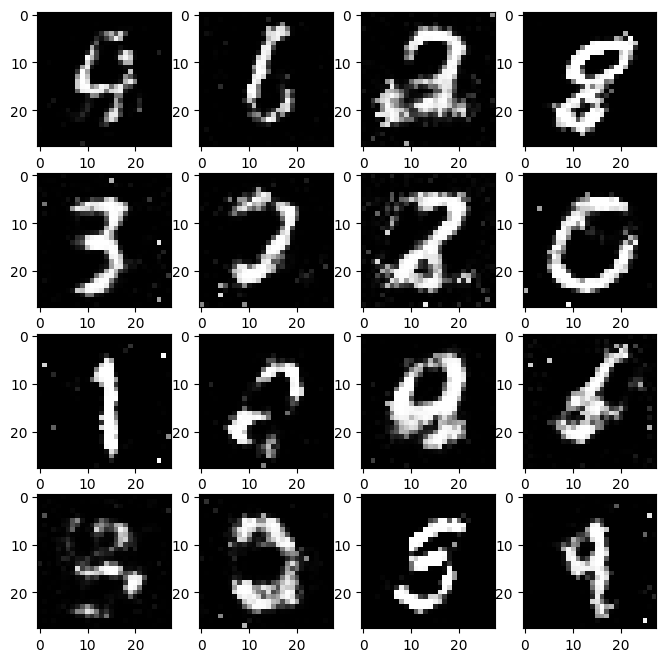

Epoch 58/100 (57.0%): [0/60032] (0.0%) D Error: 1.0745 G Error: 1.0789


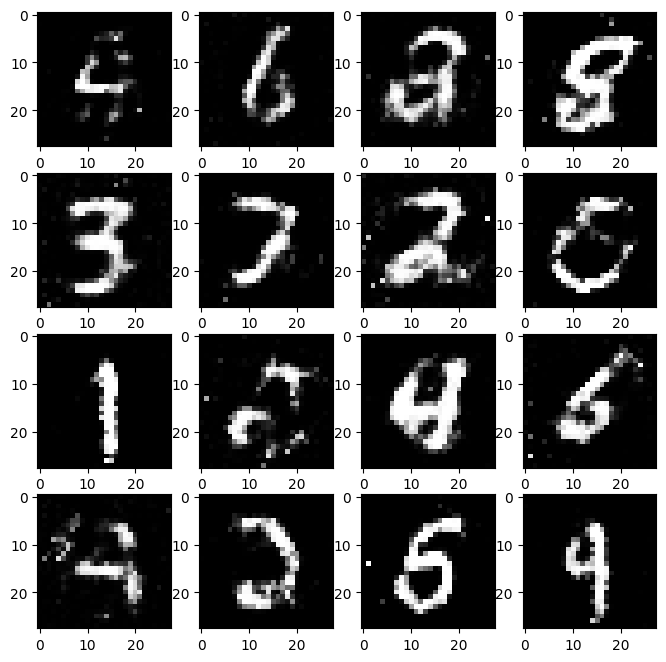

Epoch 59/100 (58.0%): [0/60032] (0.0%) D Error: 1.2601 G Error: 0.8249


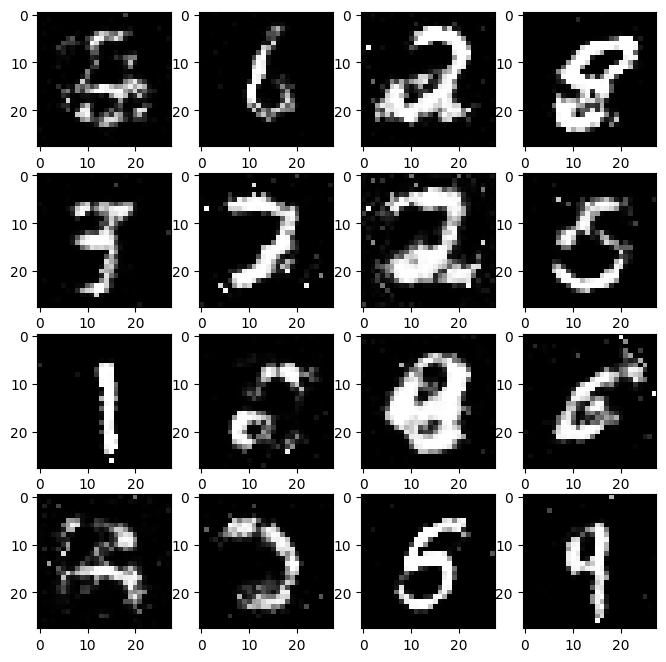

Epoch 60/100 (59.0%): [0/60032] (0.0%) D Error: 1.2003 G Error: 0.9632


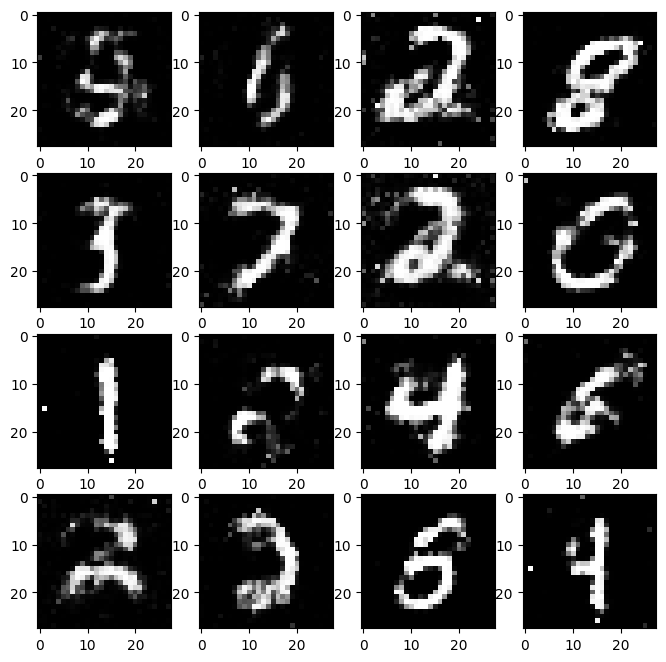

Epoch 61/100 (60.0%): [0/60032] (0.0%) D Error: 1.0391 G Error: 1.3052


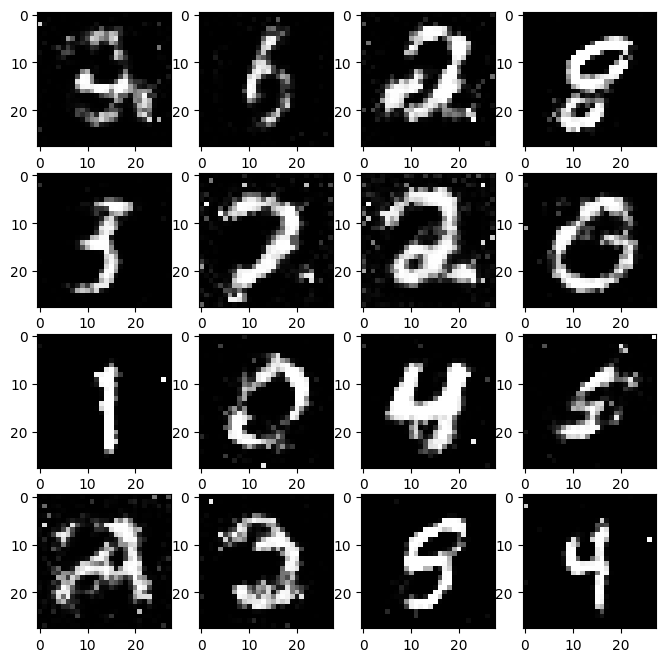

Epoch 62/100 (61.0%): [0/60032] (0.0%) D Error: 1.1139 G Error: 1.0743


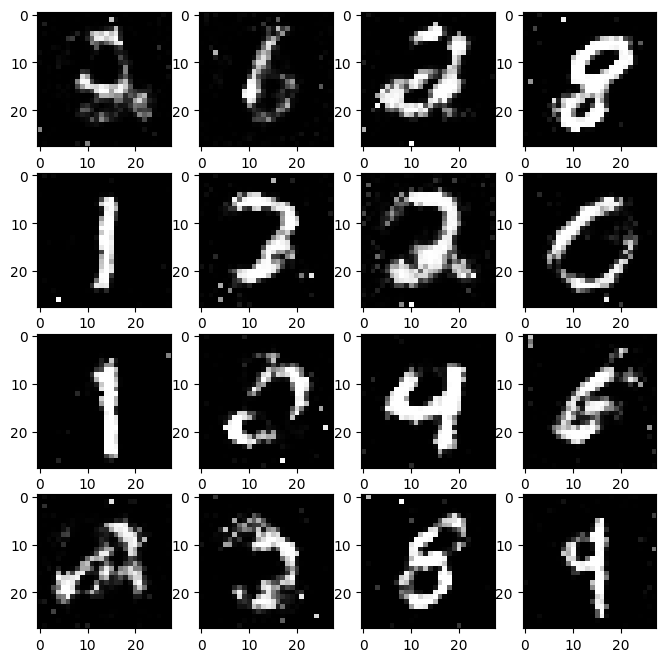

Epoch 63/100 (62.0%): [0/60032] (0.0%) D Error: 1.1629 G Error: 1.2795


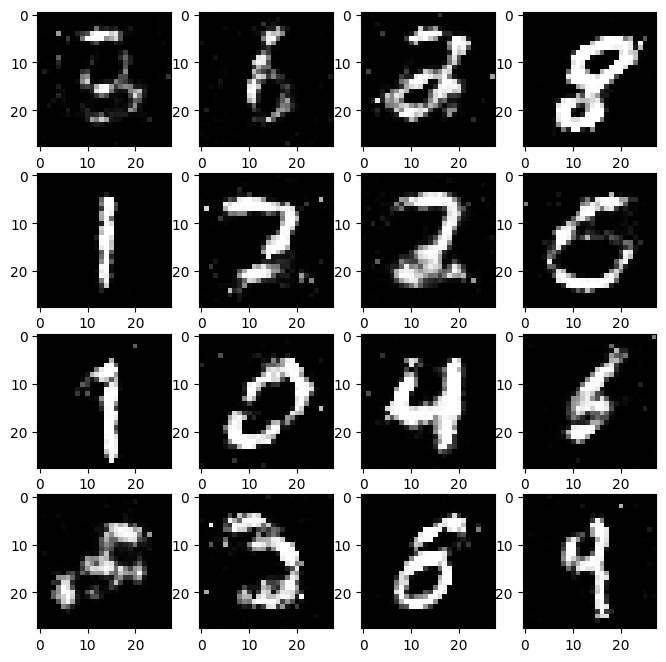

Epoch 64/100 (63.0%): [0/60032] (0.0%) D Error: 1.2326 G Error: 1.1142


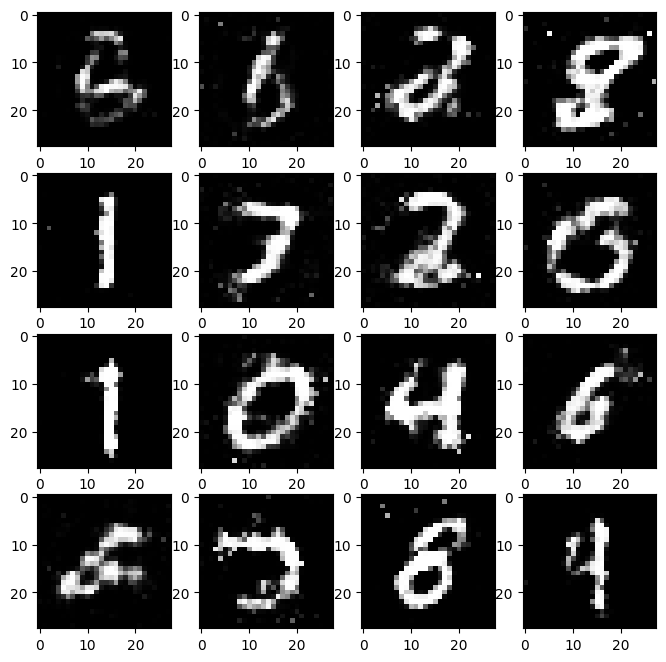

Epoch 65/100 (64.0%): [0/60032] (0.0%) D Error: 1.2715 G Error: 0.9229


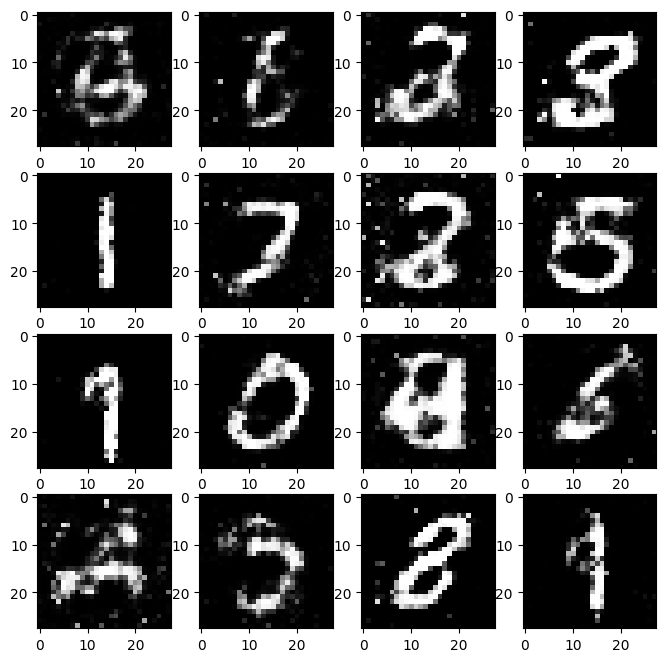

Epoch 66/100 (65.0%): [0/60032] (0.0%) D Error: 1.3096 G Error: 0.9094


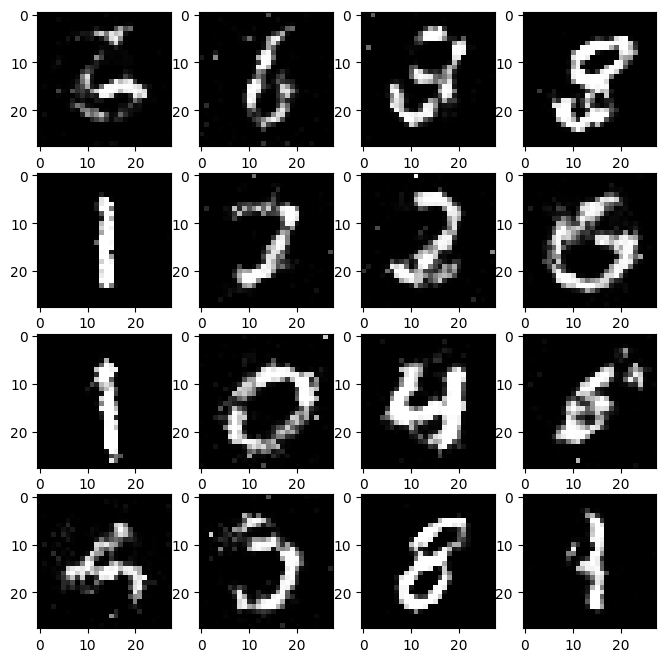

Epoch 67/100 (66.0%): [0/60032] (0.0%) D Error: 1.3330 G Error: 0.9389


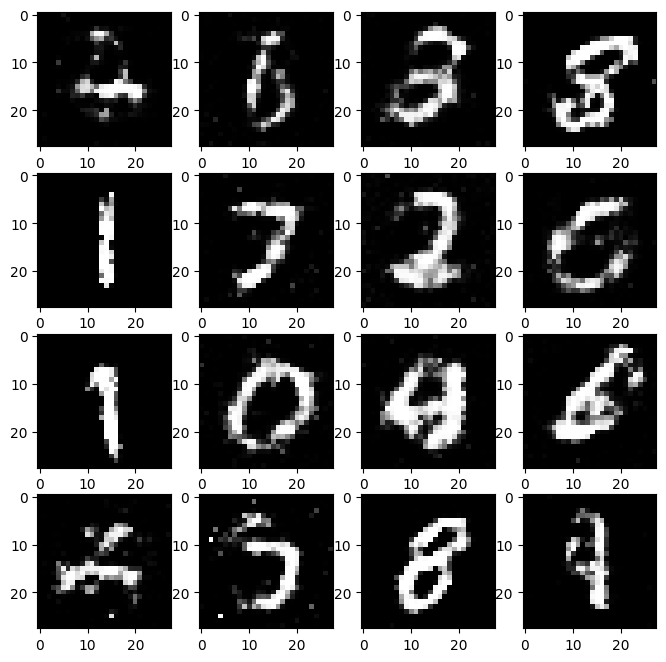

Epoch 68/100 (67.0%): [0/60032] (0.0%) D Error: 1.2613 G Error: 1.1035


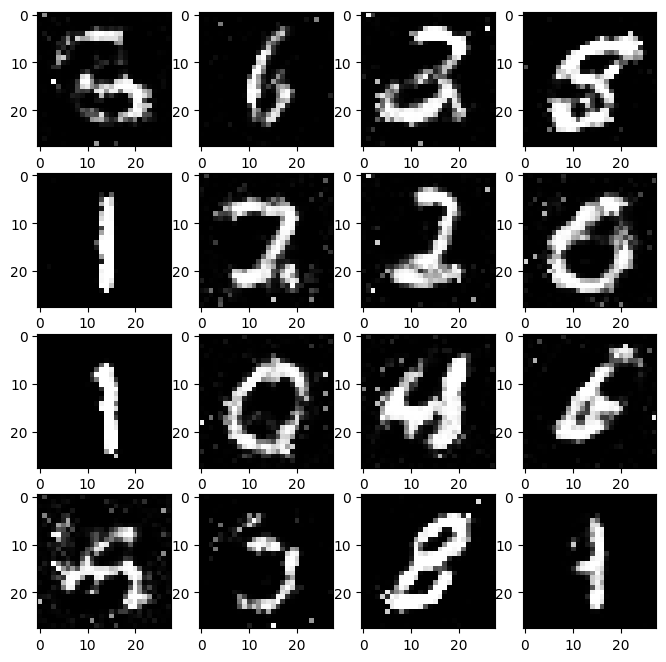

Epoch 69/100 (68.0%): [0/60032] (0.0%) D Error: 1.1951 G Error: 1.0326


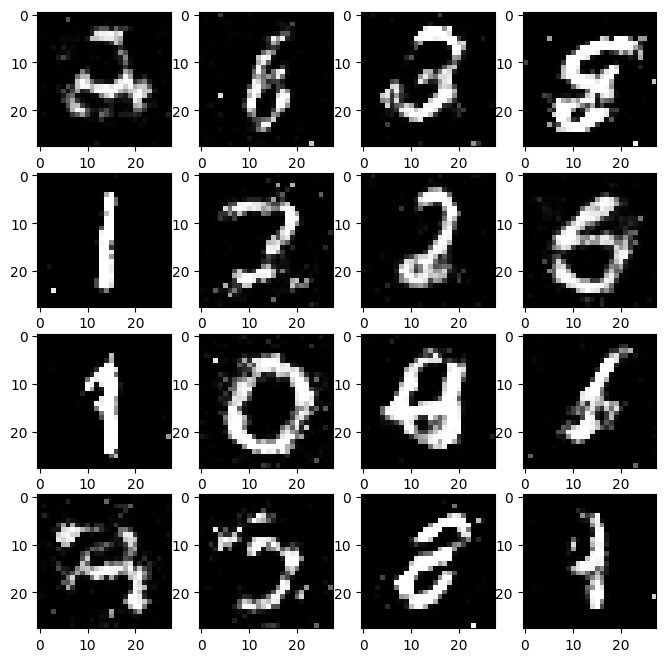

Epoch 70/100 (69.0%): [0/60032] (0.0%) D Error: 1.1363 G Error: 1.2755


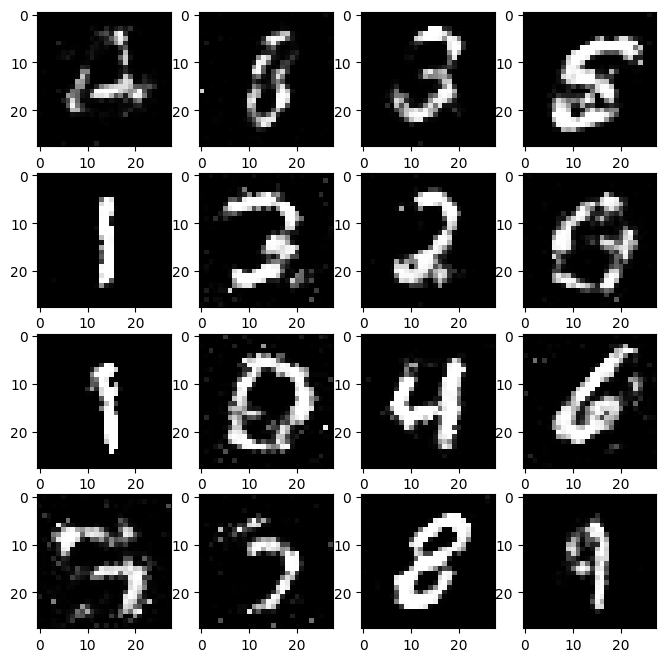

Epoch 71/100 (70.0%): [0/60032] (0.0%) D Error: 1.1570 G Error: 1.0183


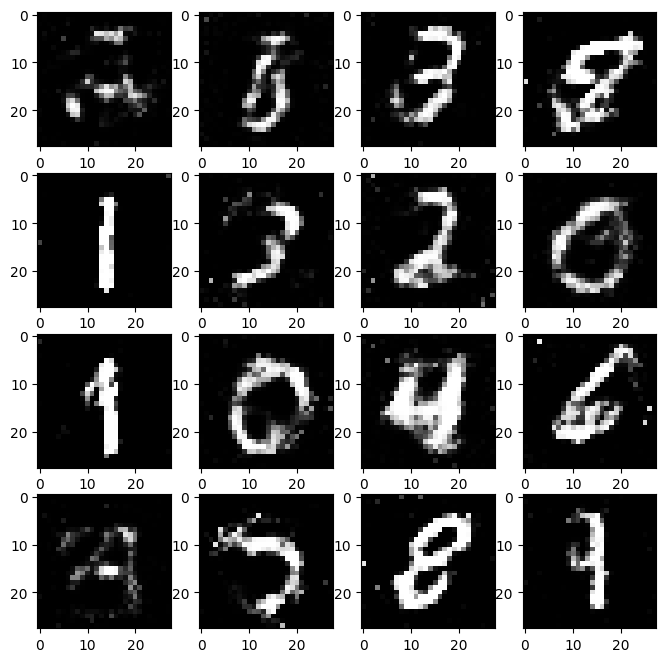

Epoch 72/100 (71.0%): [0/60032] (0.0%) D Error: 1.2498 G Error: 1.0128


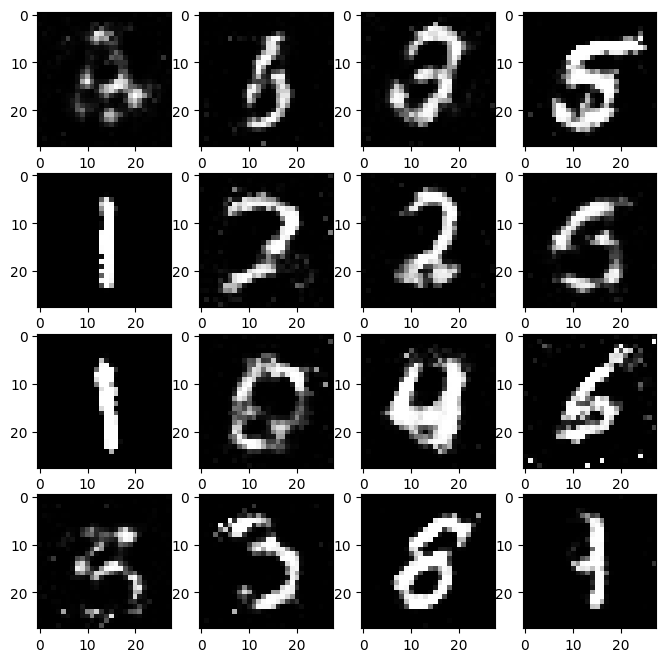

Epoch 73/100 (72.0%): [0/60032] (0.0%) D Error: 1.1200 G Error: 1.0992


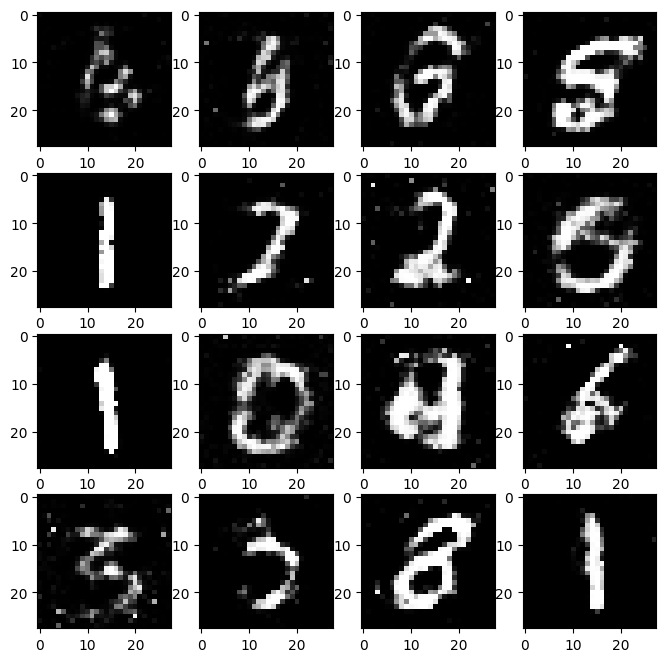

Epoch 74/100 (73.0%): [0/60032] (0.0%) D Error: 1.1793 G Error: 1.1375


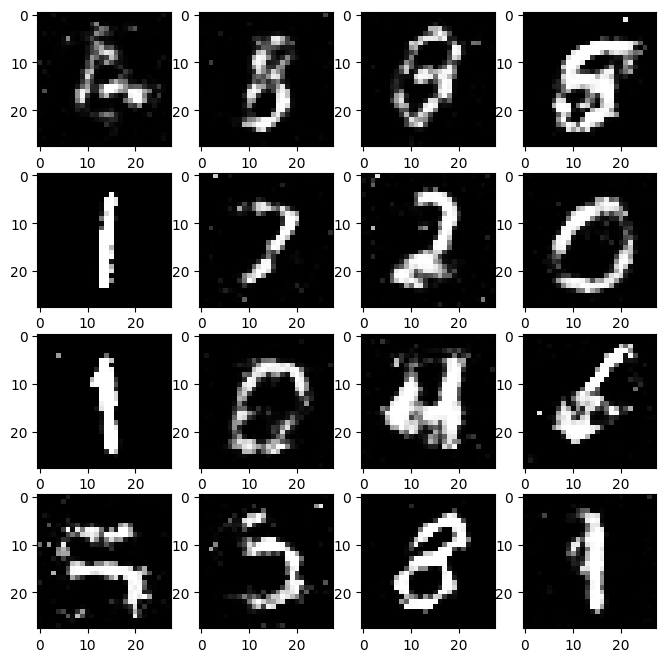

Epoch 75/100 (74.0%): [0/60032] (0.0%) D Error: 1.3945 G Error: 1.0908


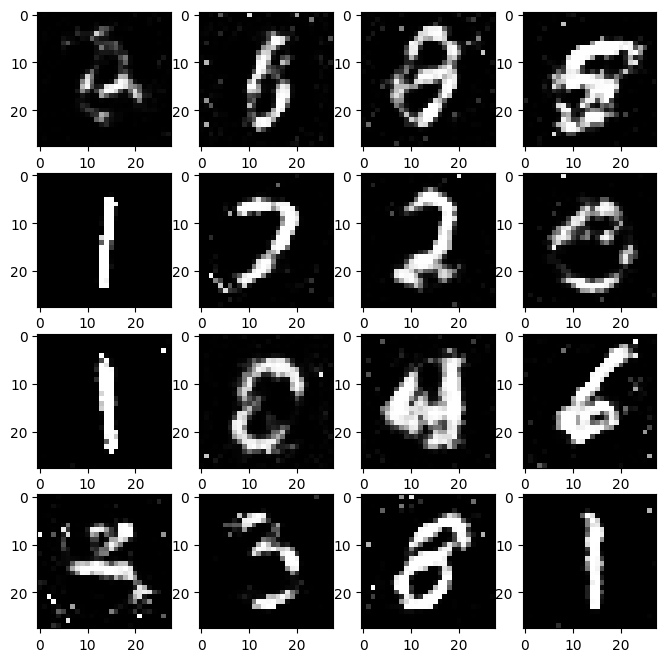

Epoch 76/100 (75.0%): [0/60032] (0.0%) D Error: 1.1953 G Error: 1.0215


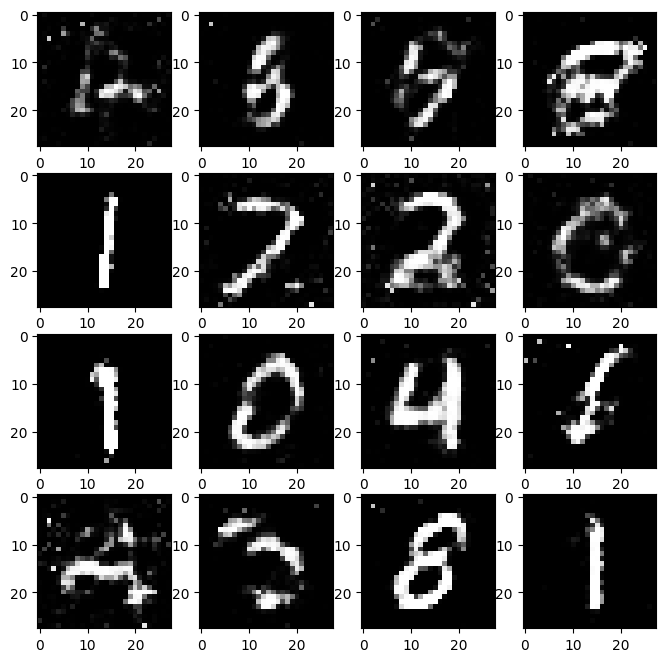

Epoch 77/100 (76.0%): [0/60032] (0.0%) D Error: 1.1021 G Error: 1.4191


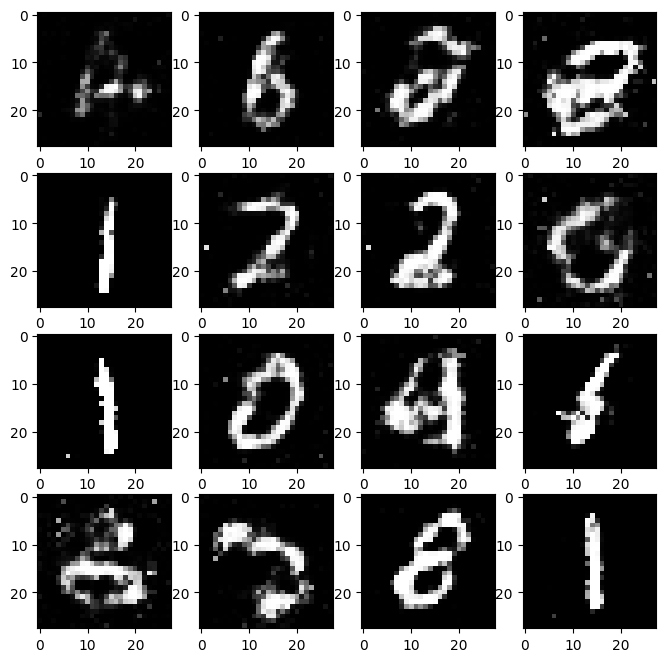

Epoch 78/100 (77.0%): [0/60032] (0.0%) D Error: 1.2872 G Error: 0.9372


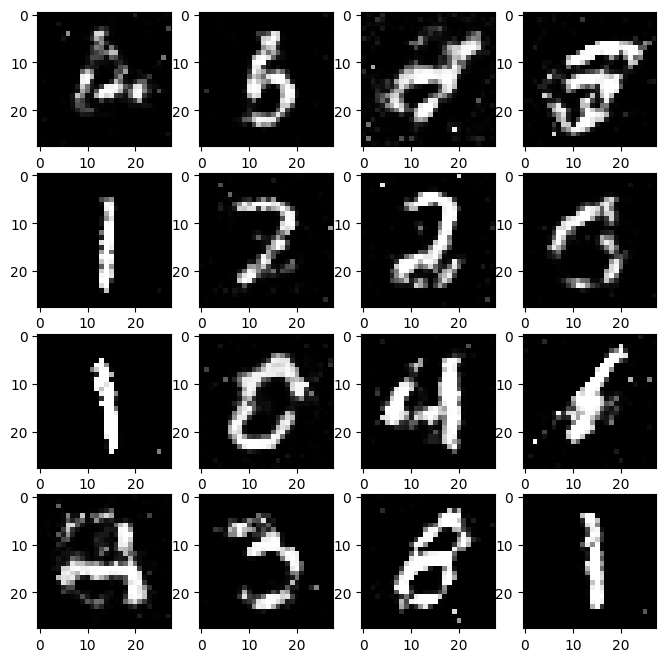

Epoch 79/100 (78.0%): [0/60032] (0.0%) D Error: 1.2367 G Error: 0.9085


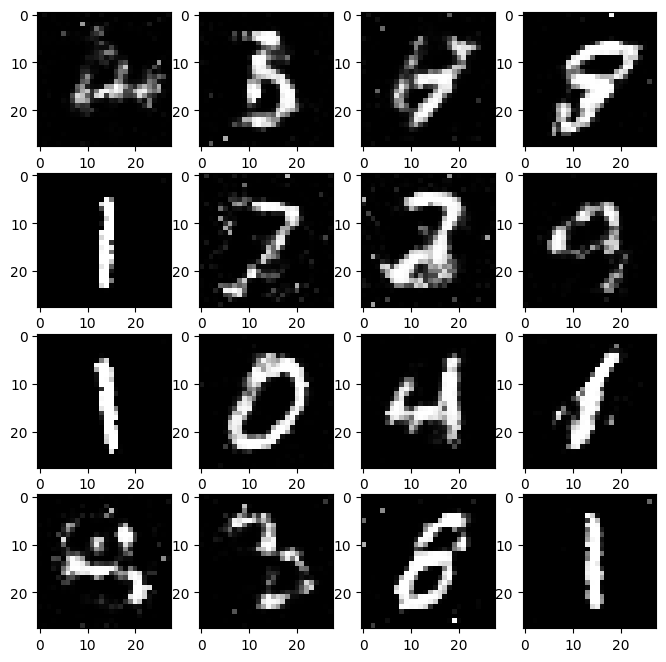

Epoch 80/100 (79.0%): [0/60032] (0.0%) D Error: 1.2572 G Error: 1.1131


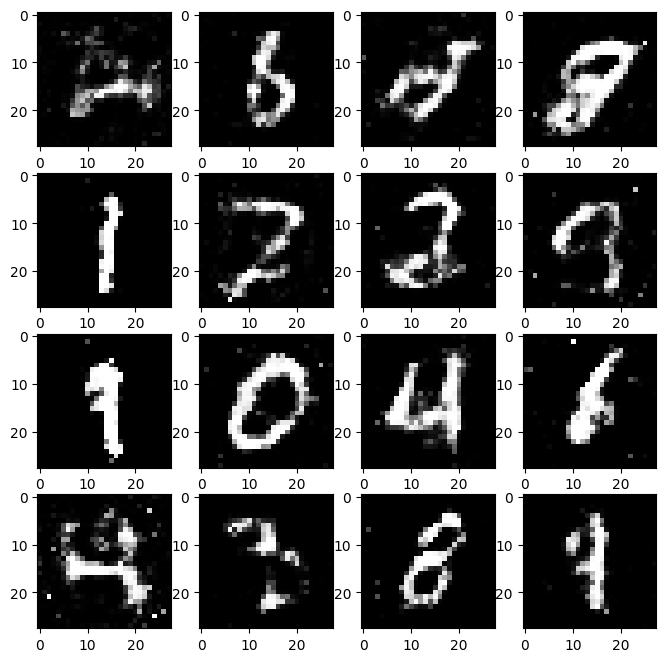

Epoch 81/100 (80.0%): [0/60032] (0.0%) D Error: 1.1303 G Error: 1.0314


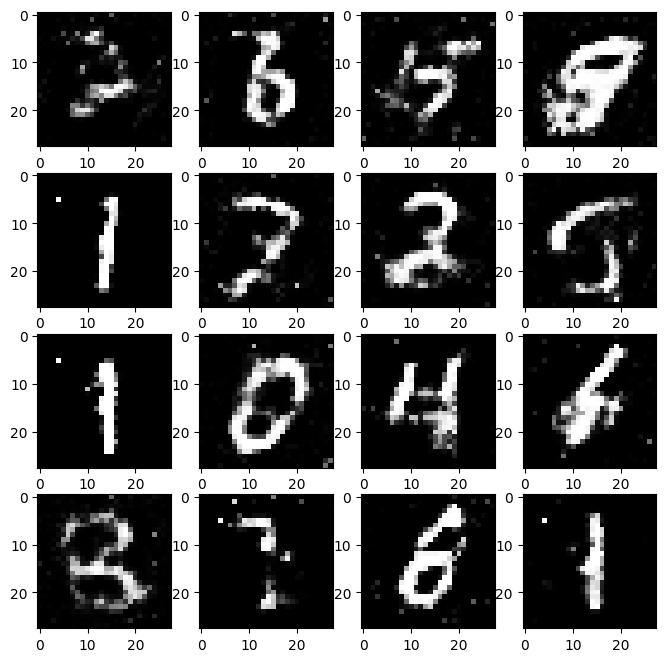

Epoch 82/100 (81.0%): [0/60032] (0.0%) D Error: 1.3222 G Error: 0.9257


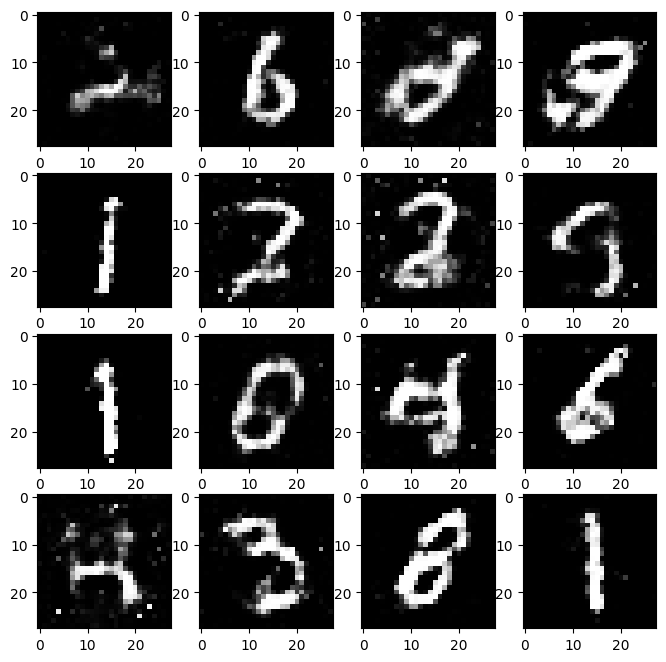

Epoch 83/100 (82.0%): [0/60032] (0.0%) D Error: 1.1685 G Error: 1.1768


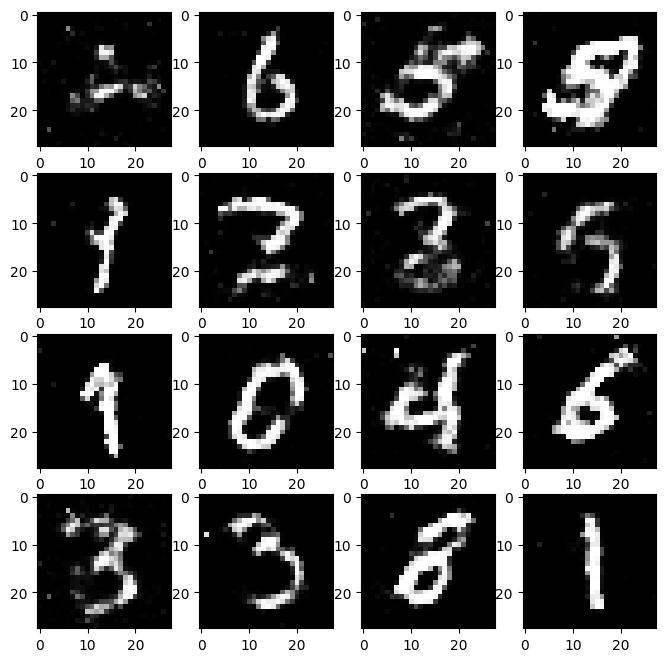

Epoch 84/100 (83.0%): [0/60032] (0.0%) D Error: 1.2472 G Error: 0.9533


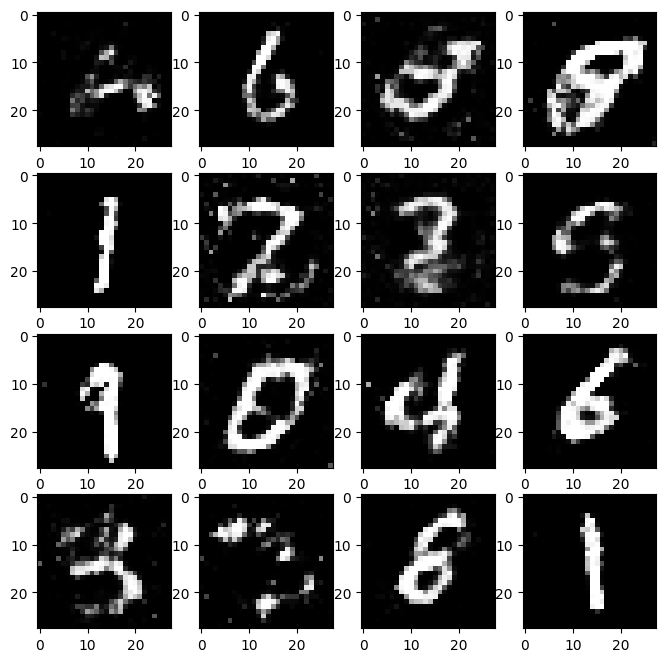

Epoch 85/100 (84.0%): [0/60032] (0.0%) D Error: 1.2149 G Error: 1.0261


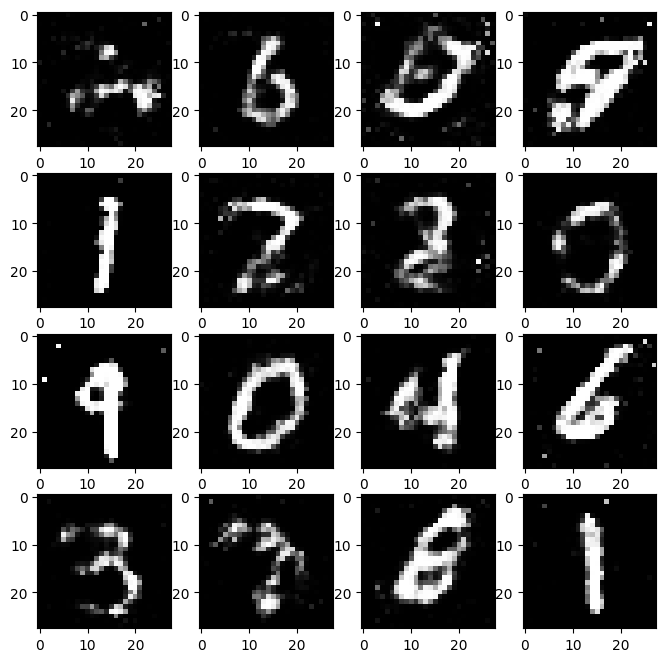

Epoch 86/100 (85.0%): [0/60032] (0.0%) D Error: 1.1710 G Error: 1.1875


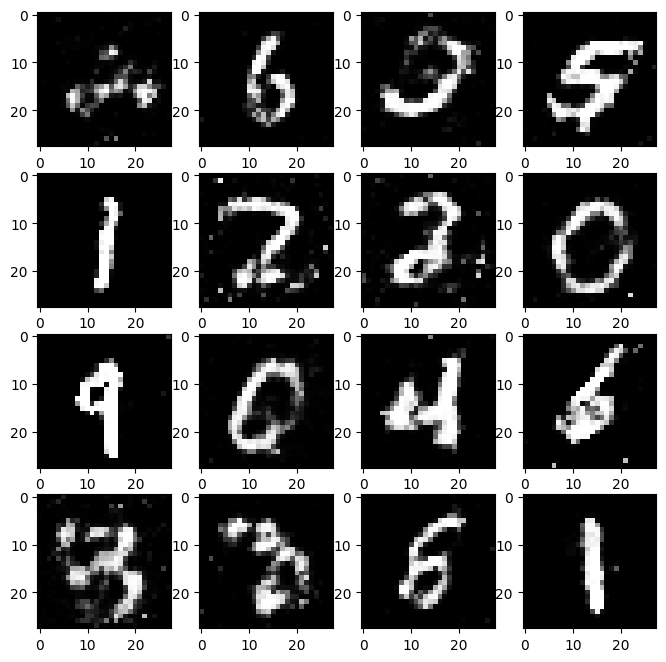

Epoch 87/100 (86.0%): [0/60032] (0.0%) D Error: 1.1877 G Error: 1.1265


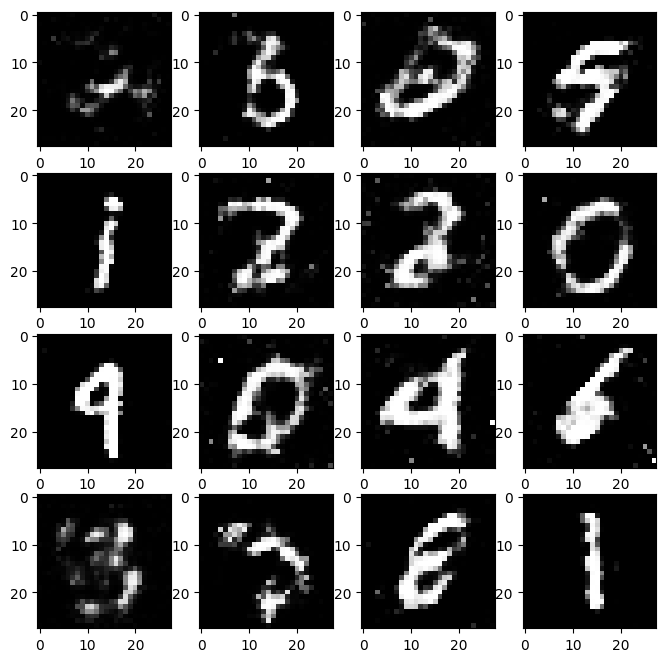

Epoch 88/100 (87.0%): [0/60032] (0.0%) D Error: 1.1271 G Error: 1.0377


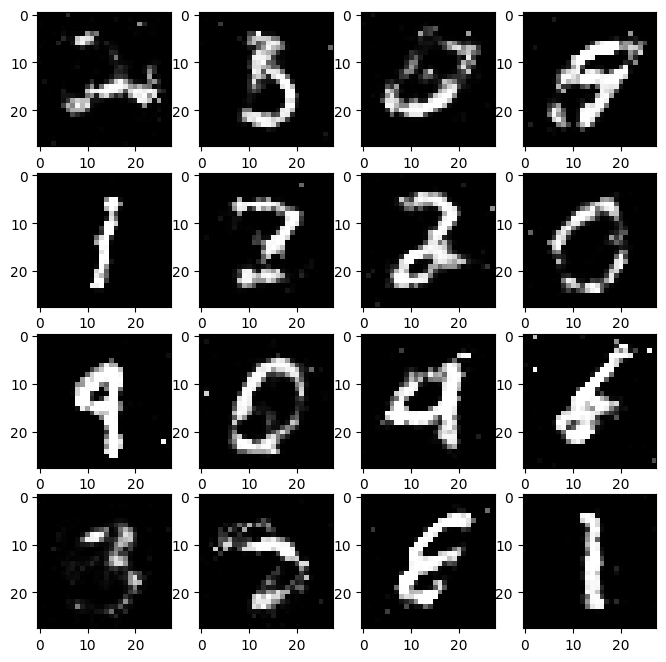

Epoch 89/100 (88.0%): [0/60032] (0.0%) D Error: 1.0889 G Error: 1.2929


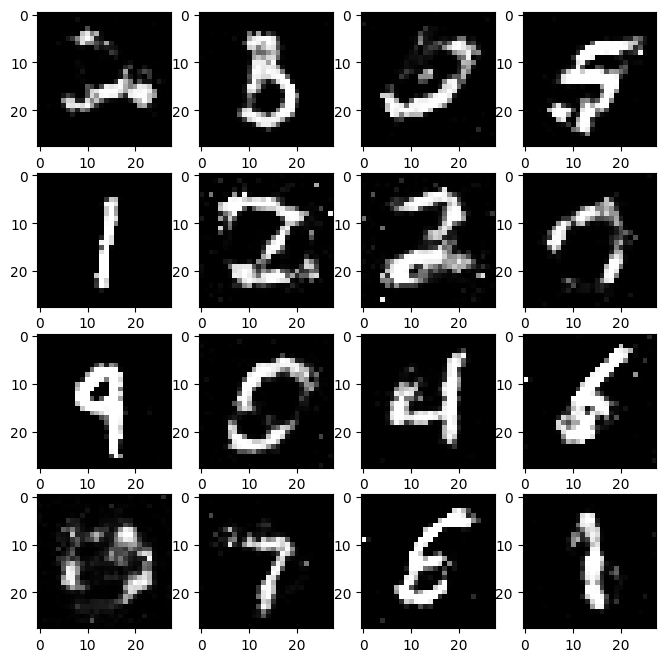

Epoch 90/100 (89.0%): [0/60032] (0.0%) D Error: 1.2040 G Error: 1.0491


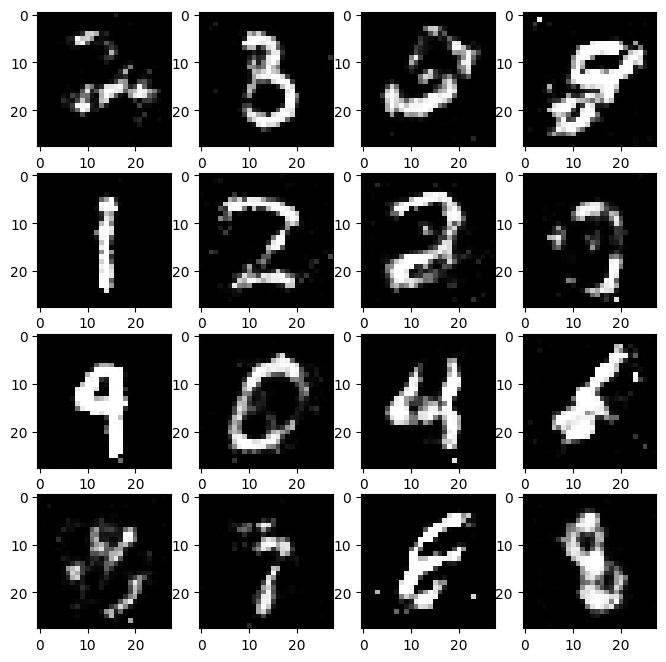

Epoch 91/100 (90.0%): [0/60032] (0.0%) D Error: 1.1135 G Error: 1.2697


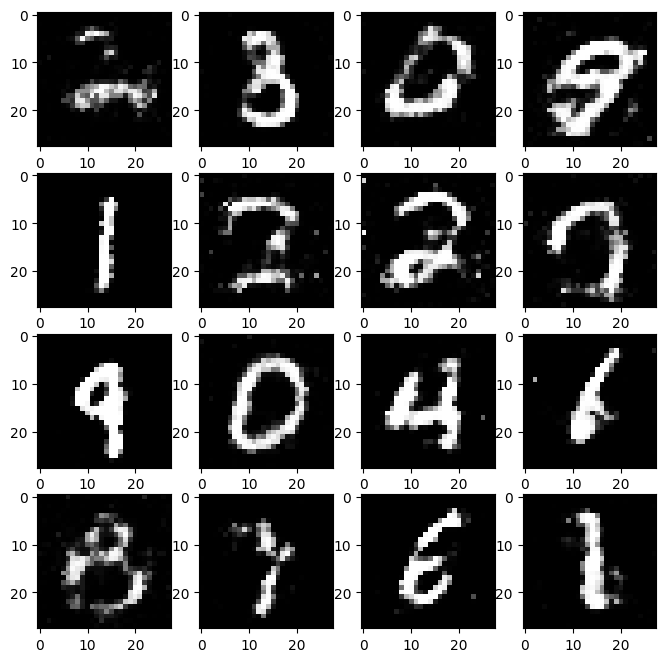

Epoch 92/100 (91.0%): [0/60032] (0.0%) D Error: 1.1958 G Error: 0.8770


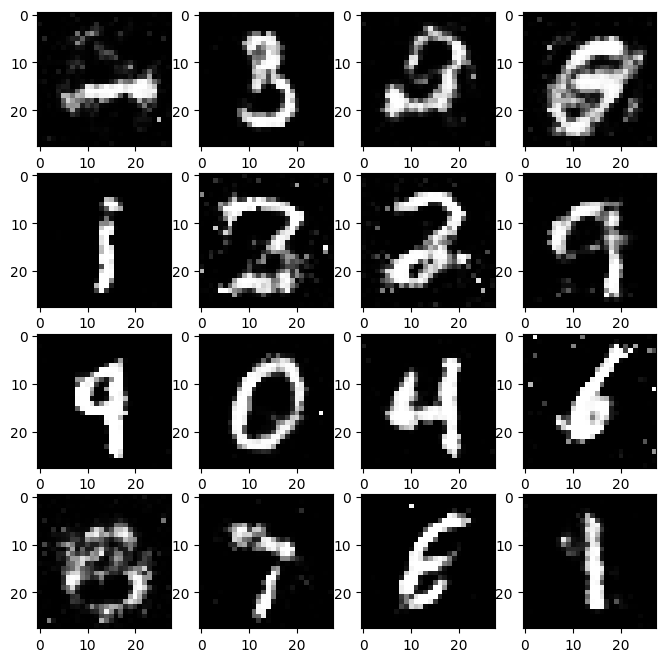

Epoch 93/100 (92.0%): [0/60032] (0.0%) D Error: 1.1839 G Error: 0.8449


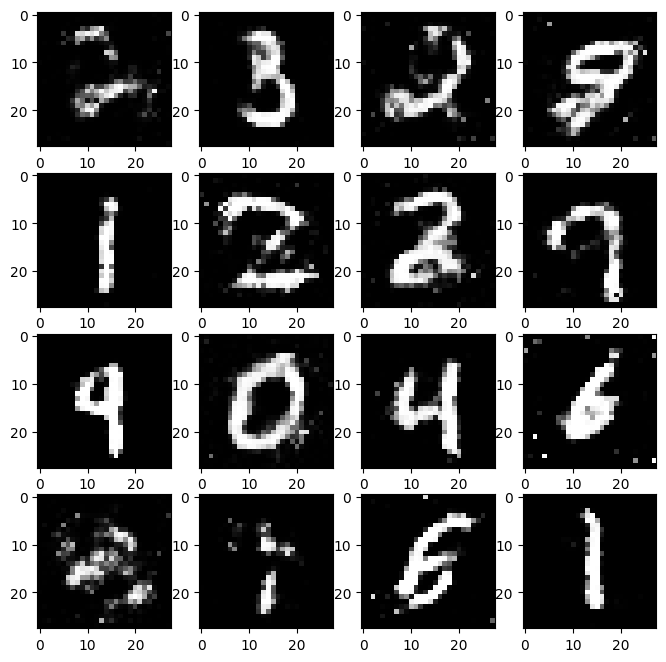

Epoch 94/100 (93.0%): [0/60032] (0.0%) D Error: 1.0733 G Error: 1.4050


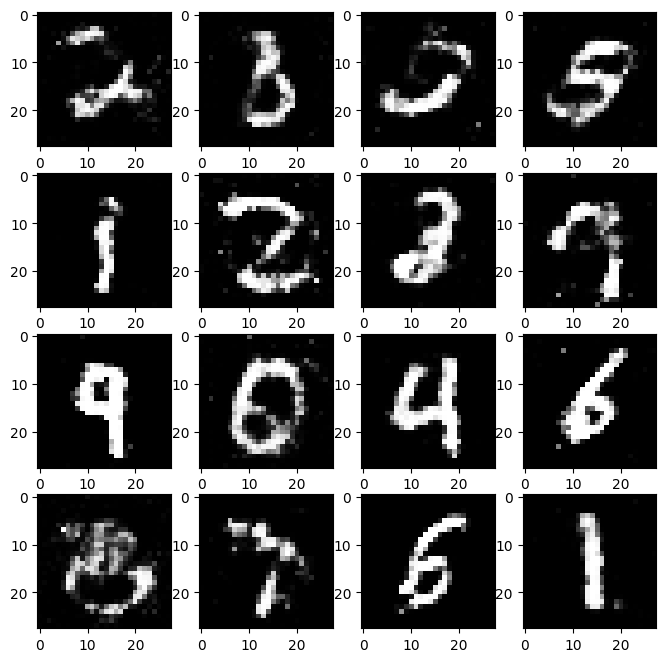

Epoch 95/100 (94.0%): [0/60032] (0.0%) D Error: 1.2346 G Error: 0.7696


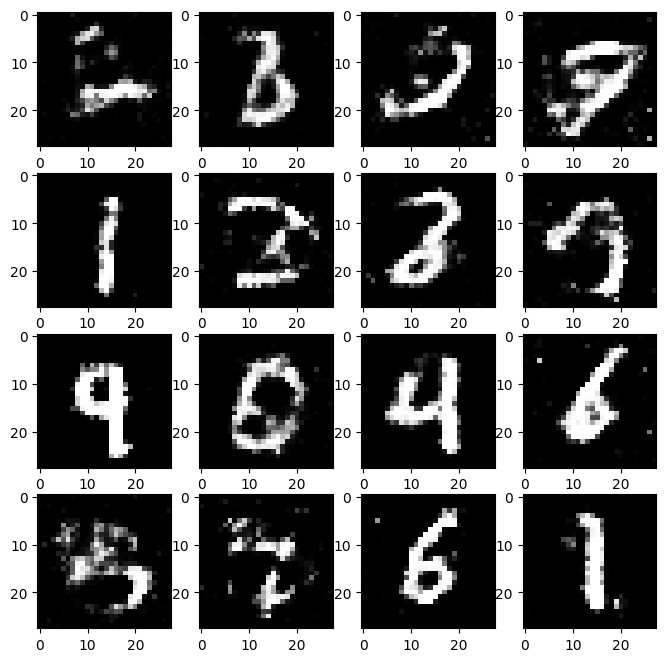

Epoch 96/100 (95.0%): [0/60032] (0.0%) D Error: 1.1956 G Error: 0.9751


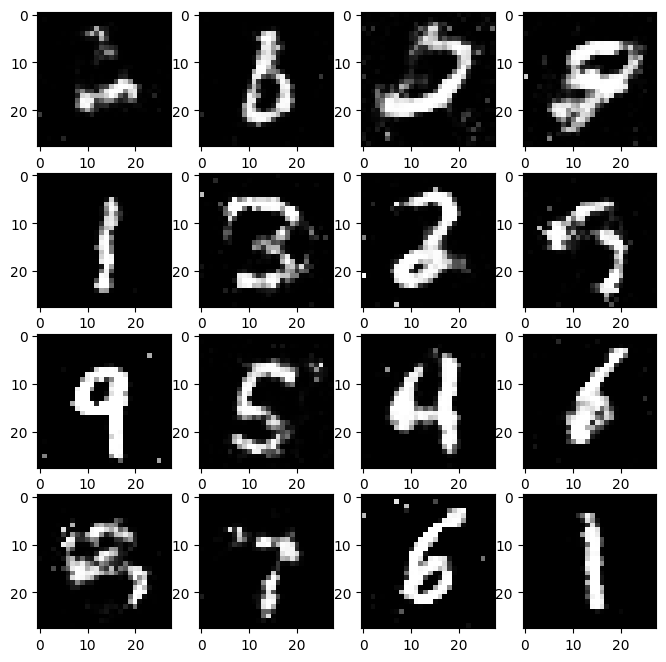

Epoch 97/100 (96.0%): [0/60032] (0.0%) D Error: 1.1234 G Error: 1.0546


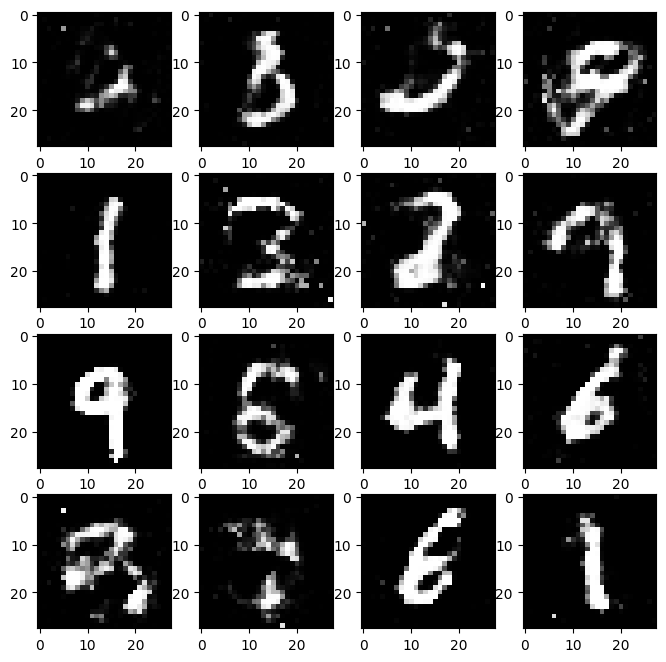

Epoch 98/100 (97.0%): [0/60032] (0.0%) D Error: 1.2945 G Error: 0.8859


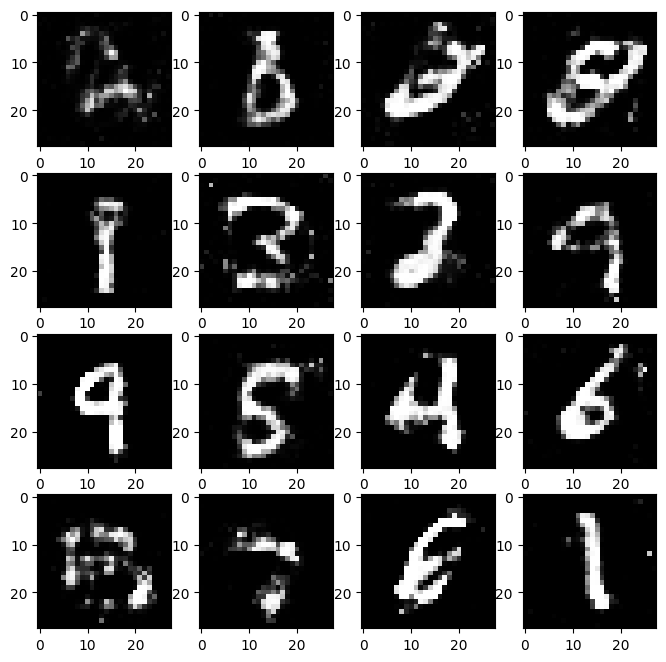

Epoch 99/100 (98.0%): [0/60032] (0.0%) D Error: 1.2829 G Error: 0.9988


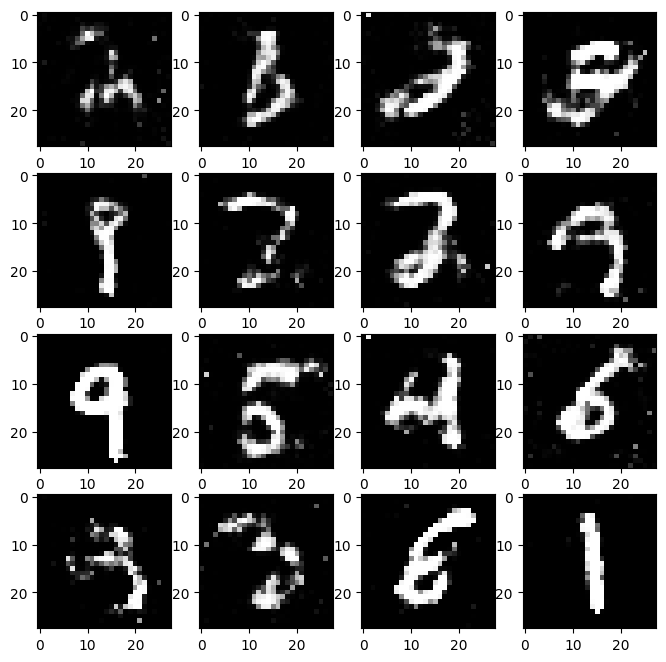

Epoch 100/100 (99.0%): [0/60032] (0.0%) D Error: 1.1363 G Error: 0.9289


In [ ]:
for epoch in range(EPOCHS):
    for batch_idx, (batch, _) in enumerate(data_loader):
        # === Train D ===
        real_data = Variable(imgs_to_vec(batch))
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake, = train_discriminator(
            discriminator, d_optimizer, loss, real_data, fake_data)
        # === Train G ===
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(
            discriminator, g_optimizer, loss, fake_data)
        # === Logging ===
        #log(d_error, g_error, epoch, batch_idx, len(data_loader))
        
        if (batch_idx % DISPLAY_EVERY) == 0:
            test_images = vec_to_imgs(generator(test_noise)).data.cpu()
            display_images(test_images)
            # Logging
            display_logs(epoch, EPOCHS, batch_idx, NUM_BATCHES,
                         d_error, g_error, d_pred_real, d_pred_fake)